# Setup: Data

## Imports

In [1]:
# imports
%load_ext autoreload

from ecast.fetch_apg_data import fetch_apg_data
from ecast.preprocess import preprocess

from copy import deepcopy
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.context("seaborn - whitegrid")
sns.set_style("whitegrid")
sns.set_context(
    "talk",
    font_scale=0.9,
    rc={
        "grid.linewidth": 0.6,
        "axes.titlesize": 22,
        "axes.titlelocation": "center",
        "axes.labelsize": 16,
        "axes.titlepad": 0,
        #         "axes.face": "smoke",
        #         "axes.xmargin":   .05,
        #         "axes.ymargin":   .05,
        "font.family": "roboto",
        #         "axes.labelsize": 12
        #         "title.y": 1.1
    })

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

from scipy import signal
import scipy.stats as scs
from scipy.stats import normaltest

from dateutil.parser import parse

import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import nsdiffs

## Inputdata 

In [2]:
# Import data
df_from_data = preprocess(fetch_apg_data())
df_from_data = df_from_data.set_index(pd.DatetimeIndex(df_from_data.index))

index=df_from_data.index
columns=df_from_data.columns

# Create scaled copies
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(df_from_data)
robust_df = pd.DataFrame(robust_df, index=index, columns=columns)

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(df_from_data)
standard_df = pd.DataFrame(standard_df, index=index, columns=columns)

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(df_from_data)
minmax_df = pd.DataFrame(minmax_df, index=index, columns=columns)

# Add datetime info columns
for _df in list([df_from_data, standard_df, robust_df, minmax_df]):

    _df['year'] = [d.year for d in _df.index]
    _df['month'] = [d.strftime('%b') for d in _df.index]

# Seed
np.random.seed(2)

# Helpers
years = df_from_data['year'].unique()
data_columns = df_from_data.columns[:-2]

## DATA COPY @ Scaling

In [3]:
### Set current data globally
df = deepcopy(df_from_data)
# df = deepcopy(robust_df)
# df = deepcopy(standard_df)
# df = deepcopy(minmax_df)

In [4]:
# Colors and units
year_colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()),
                               len(df.index.year.unique()),
                               replace=False)

colors = {
    "DA-Price": "firebrick",
    "Load": "blue",
    "Wind": "green",
    "Solar": "darkgoldenrod",
}

units = {
    "DA-Price": "Euro/MW",
    "Load": "MW",
    "Wind": "MW",
    "Solar": "MW",
}

# Setup: Functions

In [5]:
# Auto_correlation_plot
def auto_correlation_plot_1(series, color, lags=None, figsize=(14, 10)):

    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    fig, axes = plt.subplots(4, 1, figsize=(16, 16), dpi=100)

    p_value = sm.tsa.stattools.adfuller(series)[1]

    ax = sns.lineplot(
        data=series,
        x=series.index,
        y=series,
        color=color,
        ax=axes[0],
    )
    title = f'{series.name}\nDickey-Fuller-Test: sm.tsa.stattools.adfuller\n p={p_value}, lags={lags}'
    ax.set(xlabel="", ylabel=units[column], title=title)

    ax = pd.plotting.autocorrelation_plot(series.tolist(), ax=axes[1], c=color)
    ax.set(xlabel="Lags", title="Autocorrelation Full")

    smt.graphics.plot_acf(series, lags=lags, ax=axes[2], color=color, alpha=0.05, zero=False)
    smt.graphics.plot_pacf(series, lags=lags, ax=axes[3], color=color, alpha=0.05, zero=False)
    plt.tight_layout()
    
    
# Takes original, training and test df as arguments
def auto_correlation_plot_2(data, lags=50):
    
    for _df in [data]:

        fig, axs = plt.subplots(
            2,
            2,
            # sharex='col',
            sharey='row',
            figsize=(16, 8),
            gridspec_kw={
                'hspace': 0.5,
                'wspace': 0
            })
        sm.graphics.tsa.plot_acf(_df["DA-Price"],
                                 ax=axs[0][0],
                                 title="DA-Price",
                                 zero=False,
                                 color=colors["DA-Price"],
                                lags=lags)
        sm.graphics.tsa.plot_acf(_df["Load"],
                                 ax=axs[0][1],
                                 title="Load",
                                 zero=False,
                                 color=colors["Load"],
                                lags=lags)
        sm.graphics.tsa.plot_acf(_df["Wind"],
                                 ax=axs[1][0],
                                 title="Wind",
                                 zero=False,
                                 color=colors["Wind"],
                                lags=lags)
        sm.graphics.tsa.plot_acf(_df["Solar"],
                                 ax=axs[1][1],
                                 title="Solar",
                                 zero=False,
                                 color=colors["Solar"],
                                lags=lags)


In [6]:
# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
# Plot functions
def plot_df(
    data,
    x,
    y,
    title="",
    xlabel='Jahr',
    ylabel='Value',
    dpi=100,
    color="black",
    label="",
    nrows=1,
    ncols=1,
    figure=None,
):

    #     sns.lineplot(
    #         data=fmri,
    #         x="timepoint", y="signal", hue="event", style="event",
    #         markers=True, dashes=False
    #     )

    if figure is None:
        fig, ax = plt.subplots(nrows=nrows,
                               ncols=ncols,
                               figsize=(16, 6),
                               dpi=100)
#     else:
#         fig = plt.figure(figsize=(16, 6), dpi=100)
    plt.plot(x, y, color=color, alpha=0.7)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)

    return fig


# def plot_df()

# g.fig.autofmt_xdate()

# Scalings

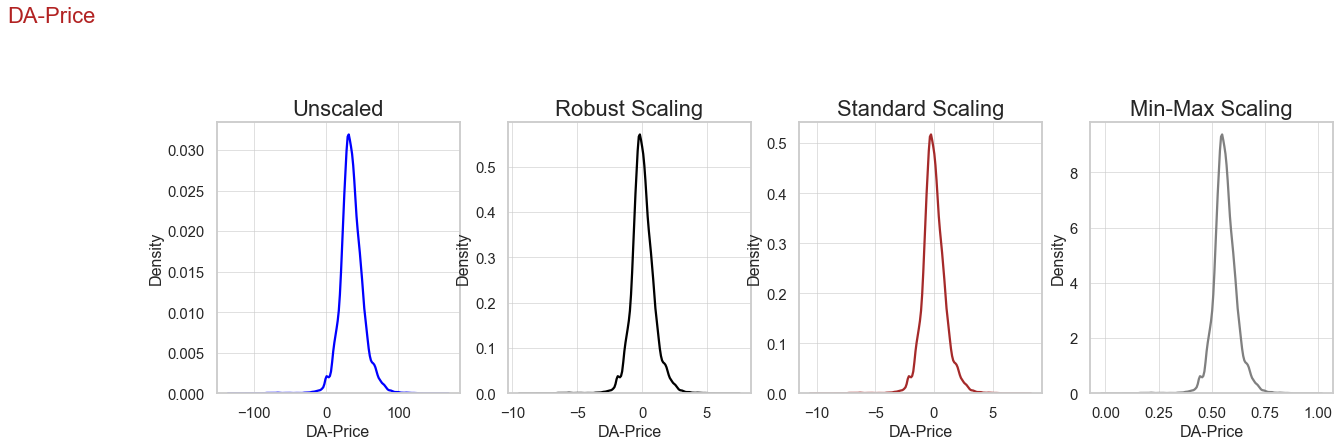

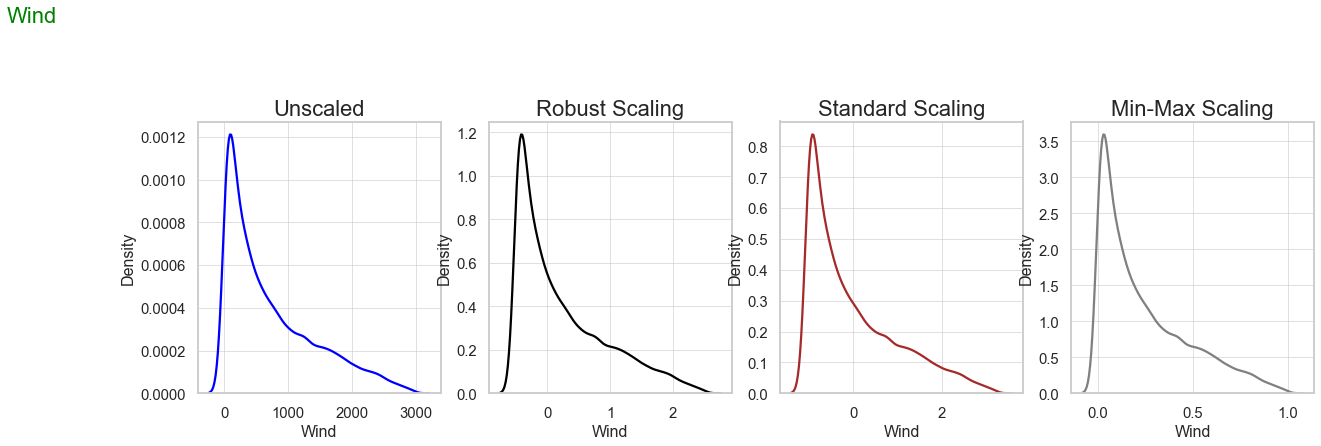

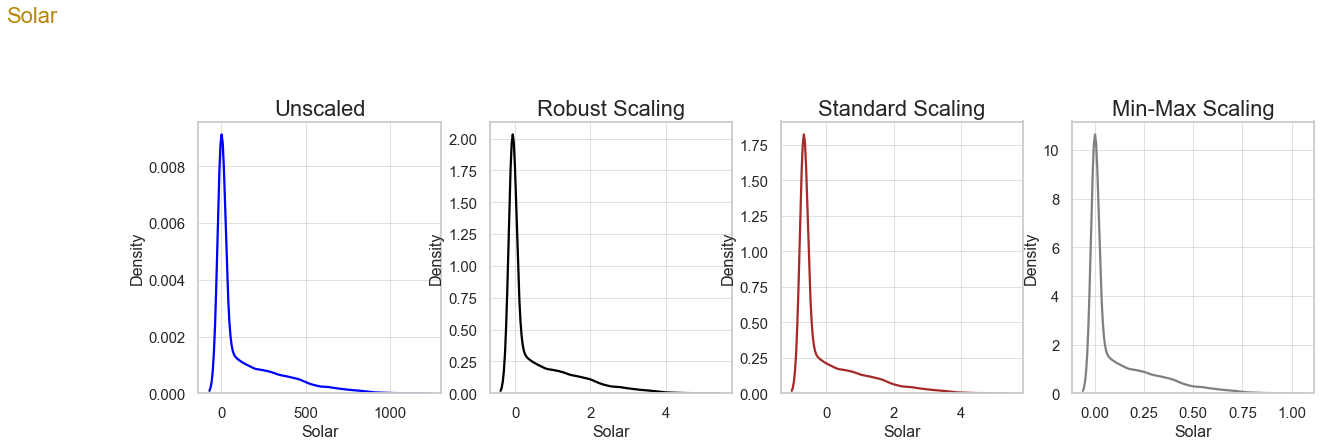

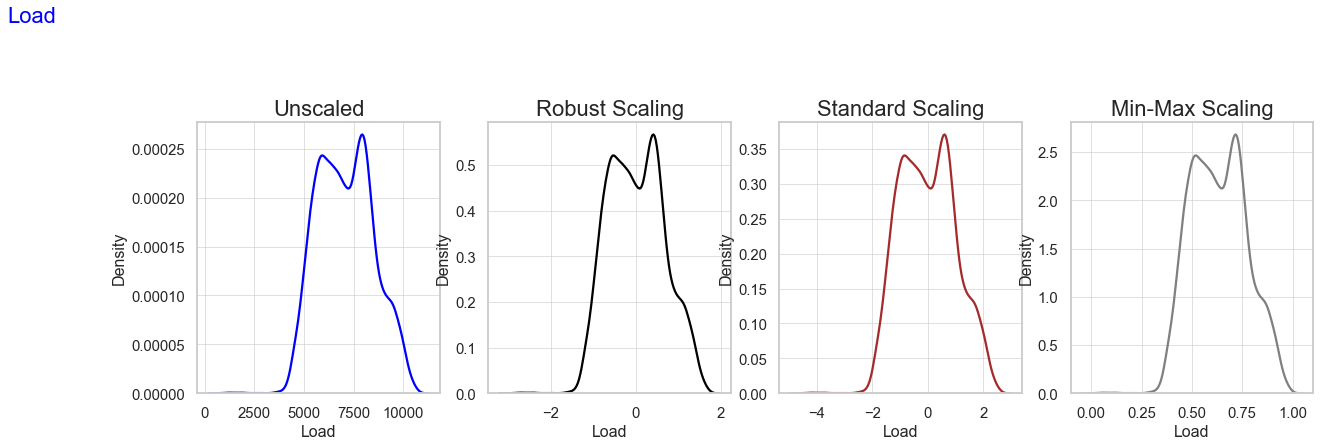

In [21]:
# Scalings
from matplotlib import rcParams
for enum, column in enumerate(data_columns):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))

    ax1.set_title('Unscaled')
    sns.kdeplot(df[column], ax=ax1, color='b')

    ax2.set_title('Robust Scaling')
    sns.kdeplot(robust_df[column], ax=ax2, color='black')

    ax3.set_title('Standard Scaling')
    sns.kdeplot(standard_df[column], ax=ax3, color='brown')

    ax4.set_title('Min-Max Scaling')
    sns.kdeplot(minmax_df[column], ax=ax4, color='grey')

    fig.suptitle(f'{column}\n',
                 fontsize=22,
                 x=0.01,
                 y=1.2,
                 color=colors[column])

# Test Normal distribution

**p-value:** Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

In the above example, D denotes the distance between our data and a Gaussian normal (norm) distribution (smaller is better), and p denotes the corresponding p-value. 

- p <= alpha: reject H0, not normal.
- p > alpha: fail to reject H0, normal.

## Kolmogorov–Smirnov test


In [23]:
# Kolmogorov–Smirnov test
print("(H0) - Null hypothesis: Data comes from a normal distribution\n")
for enum, column in enumerate(data_columns):
    D, p = scs.kstest(df[column], "norm")
    print(f"{column}\n\t Probability {round((1-D)*100,2)} %, p-value: {p}")

(H0) - Null hypothesis: Data comes from a normal distribution

DA-Price
	 Probability 2.13 %, p-value: 0.0
Wind
	 Probability 0.25 %, p-value: 0.0
Solar
	 Probability 43.21 %, p-value: 0.0
Load
	 Probability 0.0 %, p-value: 0.0


## D’Agostino’s K^2 Test

In [25]:
#D’Agostino’s K^2 Test
print("(H0) - Null hypothesis: Data comes from a normal distribution\n")
for enum, column in enumerate(data_columns):
    stat, p = normaltest(df[column])
    alpha = 0.05
    print(column)

    stat, p = normaltest(df[column])

    if p < alpha:
        print("\tThe null hypothesis can be rejected")
    else:
        print("\tThe null hypothesis cannot be rejected")

(H0) - Null hypothesis: Data comes from a normal distribution

DA-Price
	The null hypothesis can be rejected
Wind
	The null hypothesis can be rejected
Solar
	The null hypothesis can be rejected
Load
	The null hypothesis can be rejected


# Timeseries

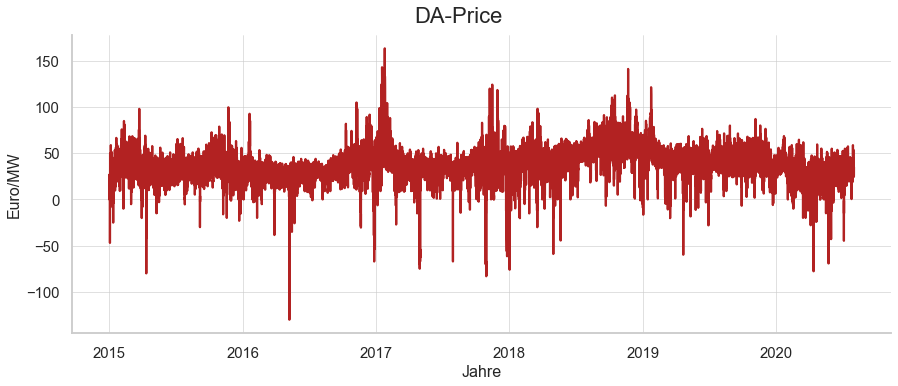

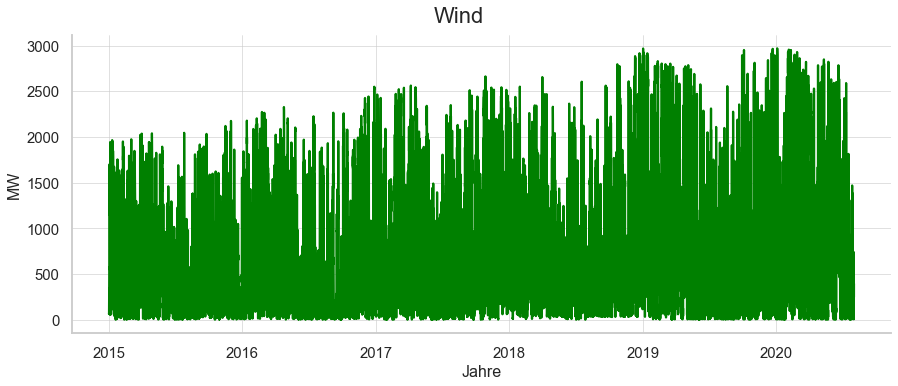

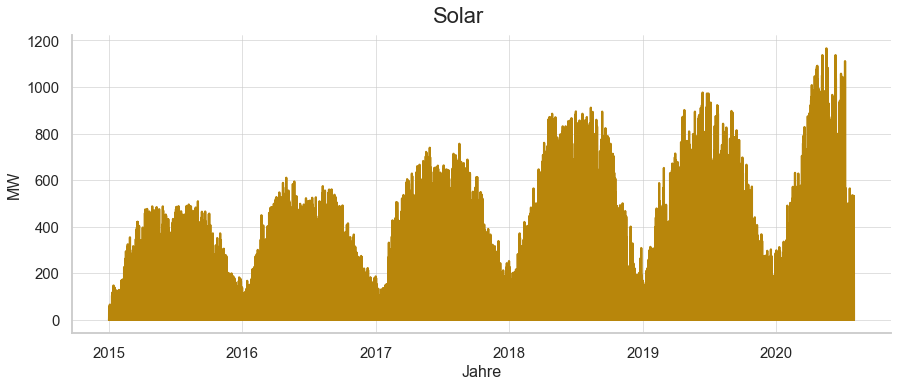

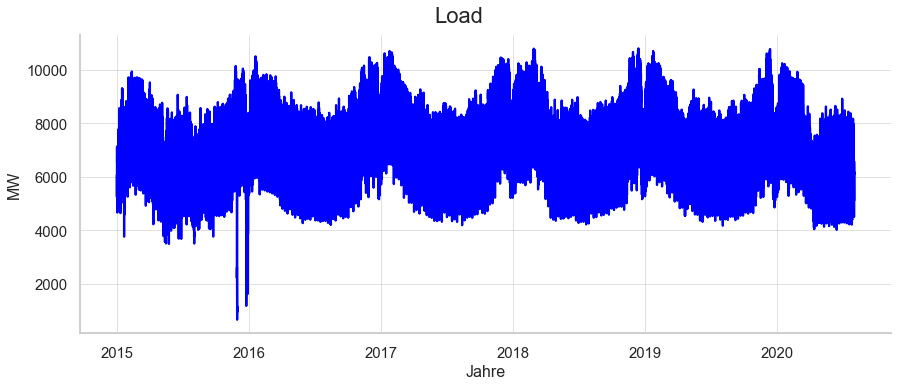

In [27]:
# APG DATA
for enum, column in enumerate(data_columns):

    ax = sns.relplot(
        data=df[column],
        x=df.index,
        y=df[column],
        kind="line",
        ci=None,
        height=5,
        aspect=2.5,
        color=colors[column],
    )
    ax.set(xlabel="Jahre", ylabel=units[column])
    plt.suptitle(t=column, size=22, y=1.03)
#     ax.fig.autofmt_xdate()

# Seasons

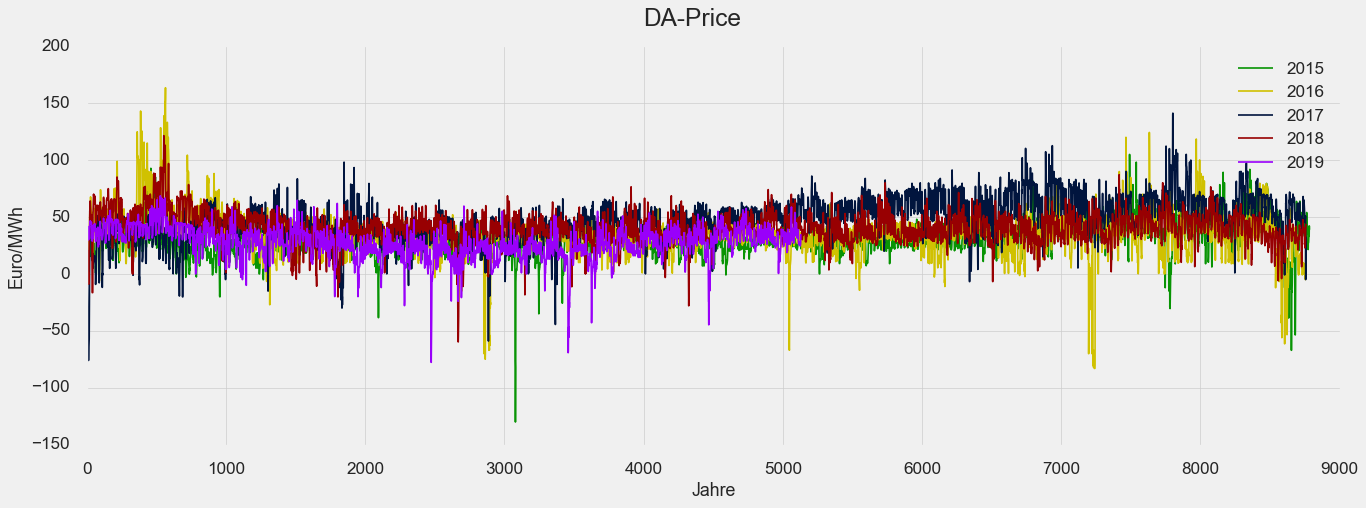

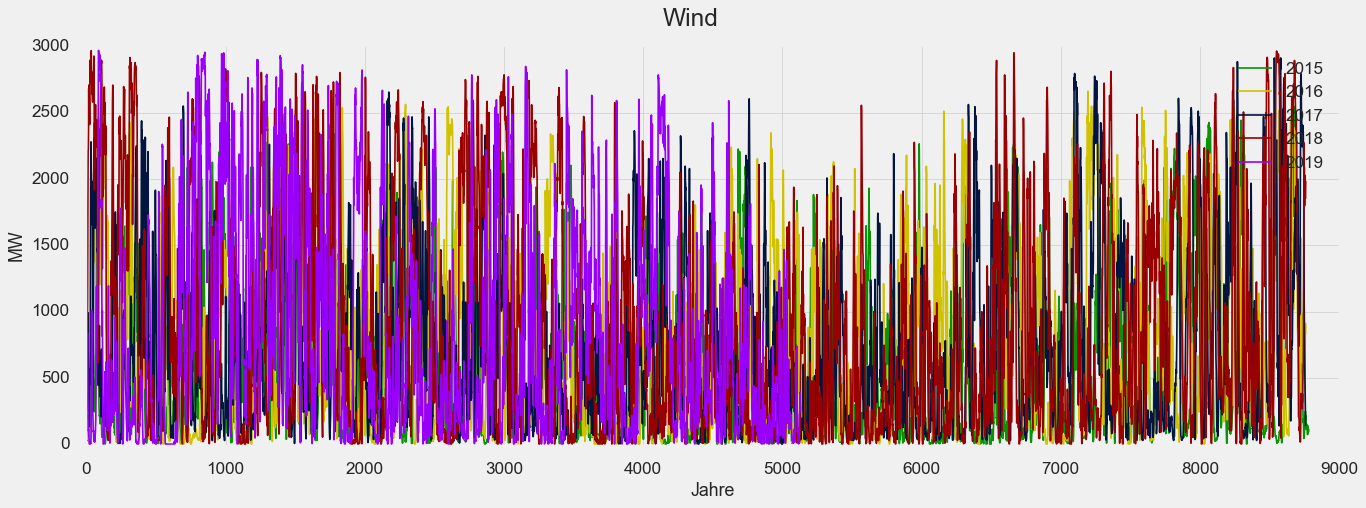

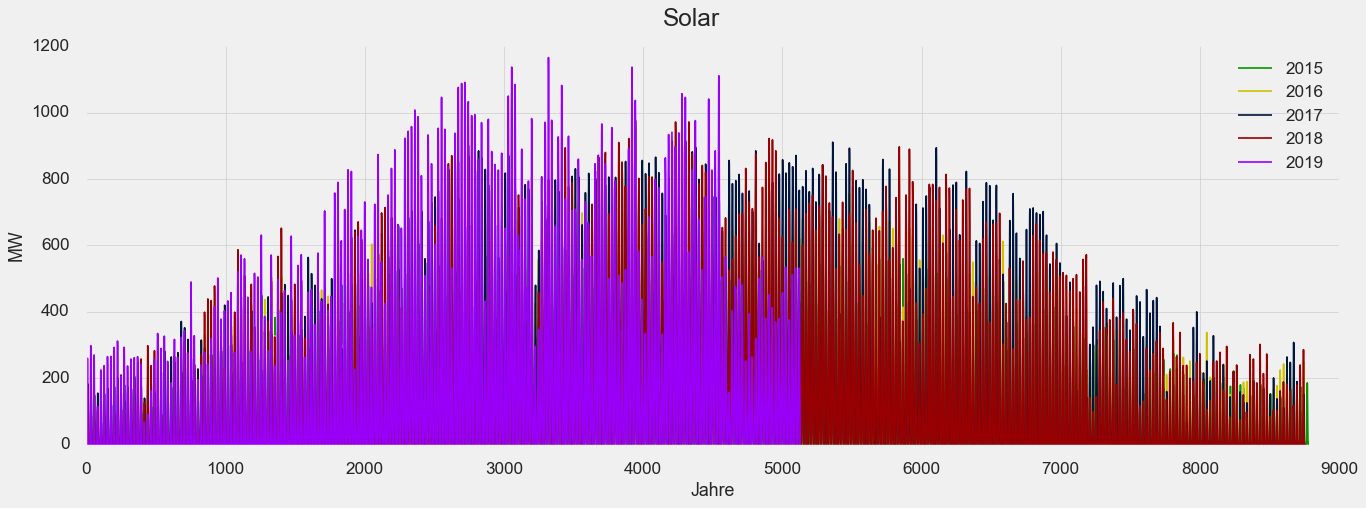

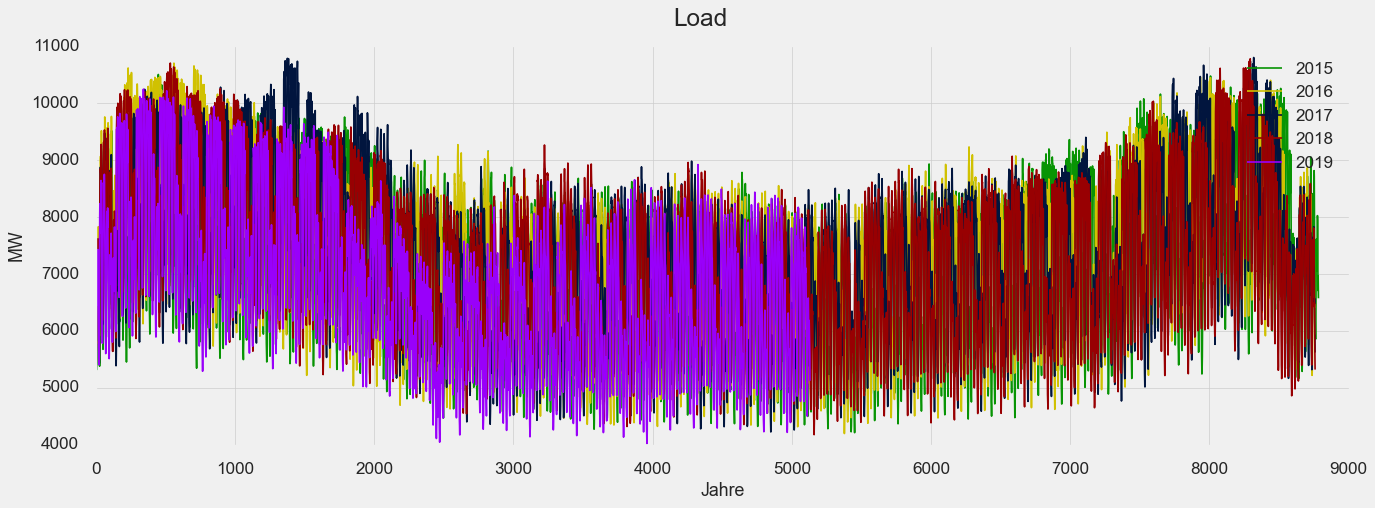

In [230]:
# Seasonal overlay
for enum, column in enumerate(data_columns):
    fig = plt.figure(figsize=(18, 6), dpi=80)
    ax = plt.axes()

    for i, y in enumerate(years):
        if i > 0:  #
            data = df.loc[df.year == y]
            sns.lineplot(
                ax=ax,
                data=df[column],
                x=list(range(len(data.index))),
                y=data[column],
                color=year_colors[i],
                ci=None,
            )
            # Axes labels
            ax.set(xlabel="Jahre", ylabel=units[column])
            # Title
            plt.suptitle(t=column, size=22)
            # Legend
            plt.gca().legend(years)

# Boxplots

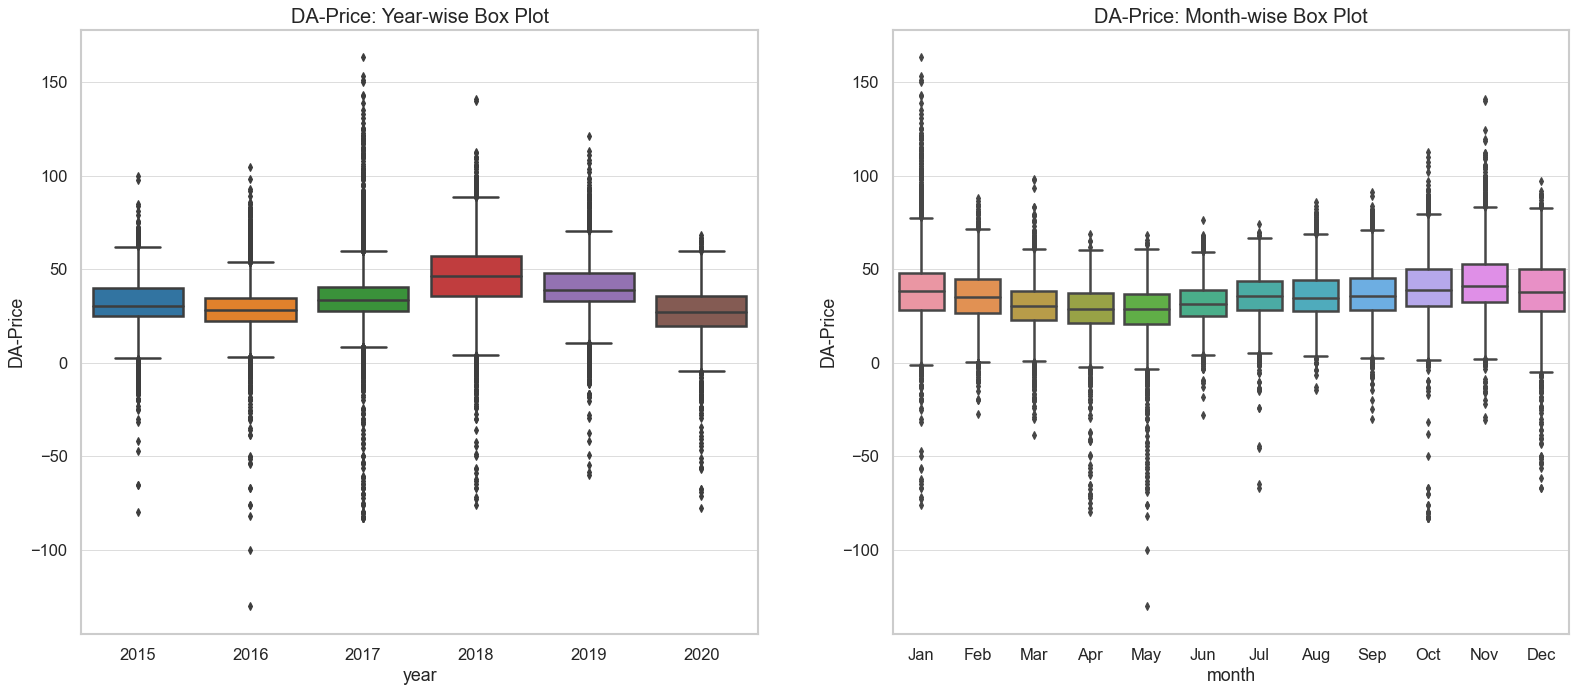

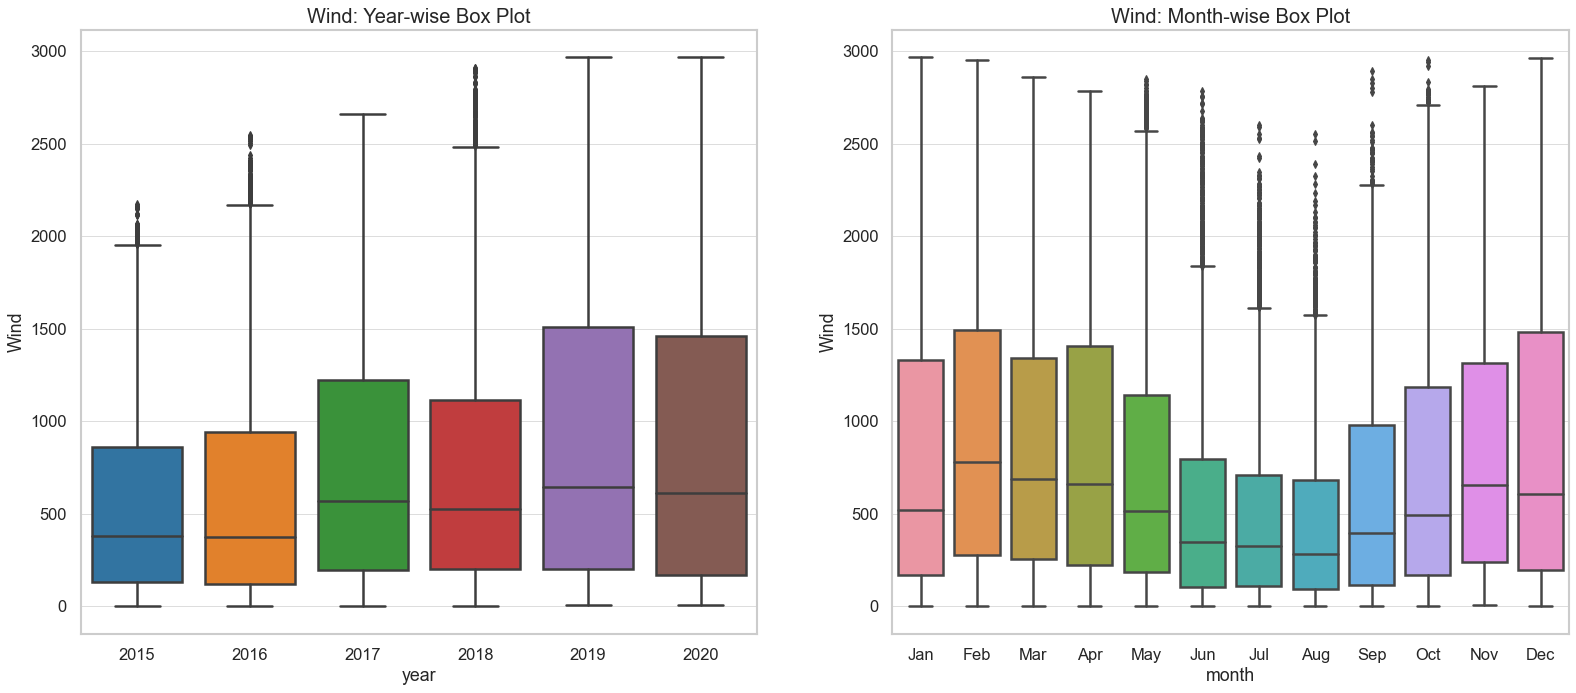

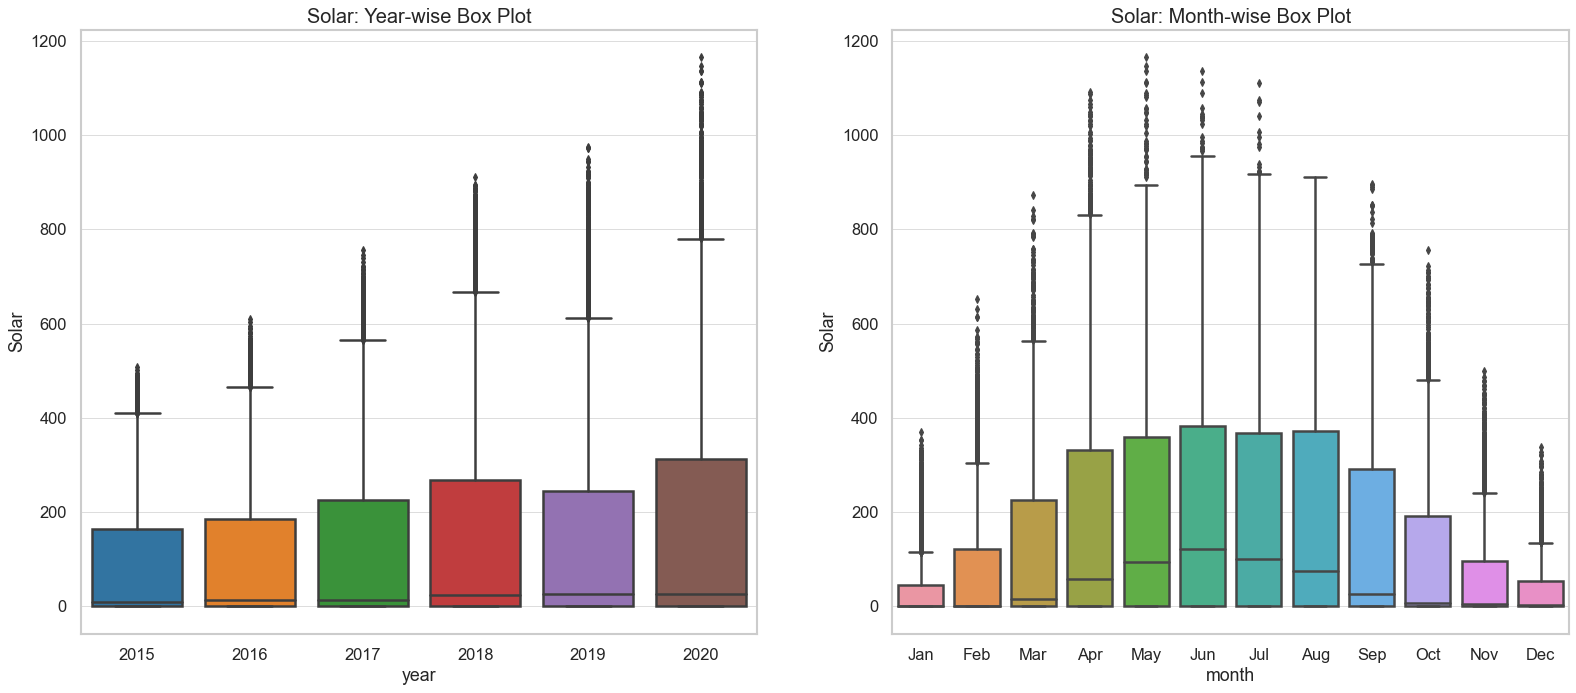

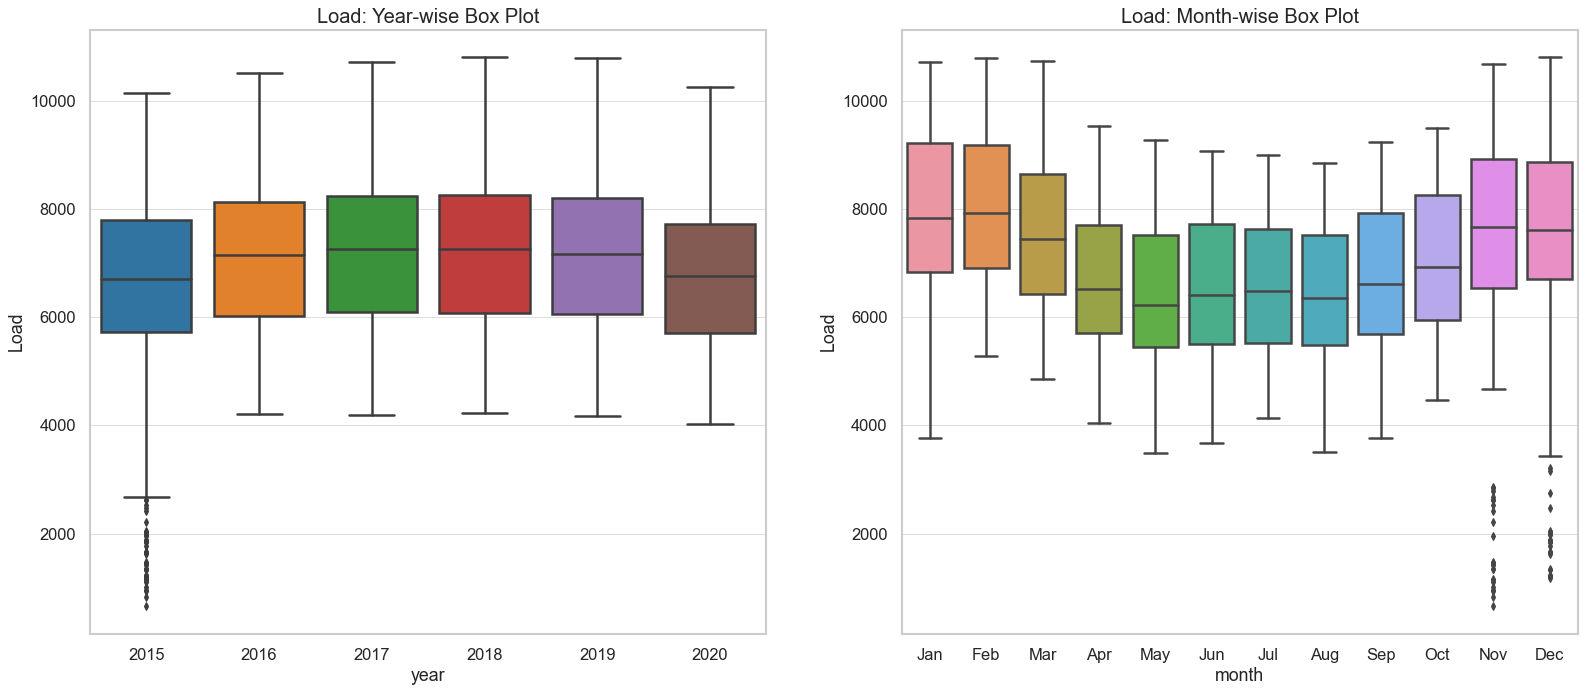

In [29]:
# Boxplots per year and month
def box_plot_per_year_and_month():
    for enum, col in enumerate(df[data_columns]):

        # Draw Plot
        fig, axes = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
        sns.boxplot(x='year', y=df[col], data=df, ax=axes[0])
        sns.boxplot(x='month', y=df[col], data=df)

        # Set Title
        axes[0].set_title(f'{col}: Year-wise Box Plot', fontsize=18)
        axes[1].set_title(f'{col}: Month-wise Box Plot', fontsize=18)


box_plot_per_year_and_month()

# Seasonal Decomposition


## Models

### Classic Moving Average

For additive decomposition the process (assuming a seasonal period of m) is carried out as follows:

1) Compute the “trend-cycle” component $\hat{T}_{t}$ using a $2\times m \textrm- MA$ if m is an even number, or using an $m \textrm- MA$ if m is an odd number.

2) Calculate the detrended series: $y_{t} - \hat{T}_{t}$

3) The seasonal component for each season if then calculated by simply averaging the detrended values for that season. So if we are dealing with monthly data, the seasonal component for December, for example, would just be the average of all the detrended December values in the data. Adjustments to these monthly values are made to ensure that they all sum to zero, and then they are strung together and the sequence is replicated for each year of data: the output of this is $\hat{S}_{t}$

4) The final step is to calculate the noise component by subtracting the estimated “seasonal” and “trend-cycle” components: $\hat{R}_{t}  = y_{t} - \hat{S}_{t}$

Classical multiplicative decomposition is similar, except that the subtractions are replaced by divisions.


The additive model formula is $$Y[t] = T[t] + S[t] + e[t]$$

The multiplicative model formula is $$Y[t] = T[t] * S[t] * e[t]$$

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.

The frequency of decomposition must be an interval, which 'may' repeat (e.g. 7 days) 

$$ 1 week = 24h * 7days$$

Source: https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/

In [17]:
# Decomposition frequency
# extrapolate_trend = 24 # Daily
# extrapolate_trend = 24 * 7 # Weekly
# extrapolate_trend = 24 * 31 # Monthly
extrapolate_trend = "freq"

# resample = "H"  # hourly
# resample = "D" # daily
resample = "M"  # daily
# resample = "Y" # daily

# model = "additive"
model="multiplicative"

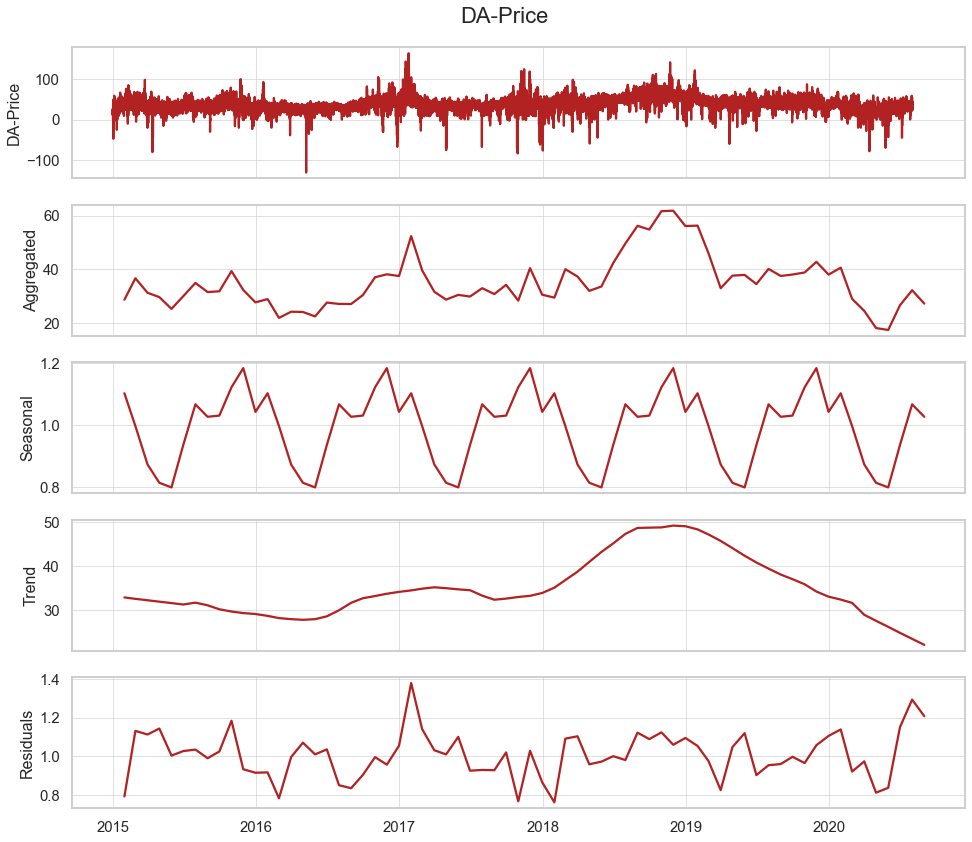

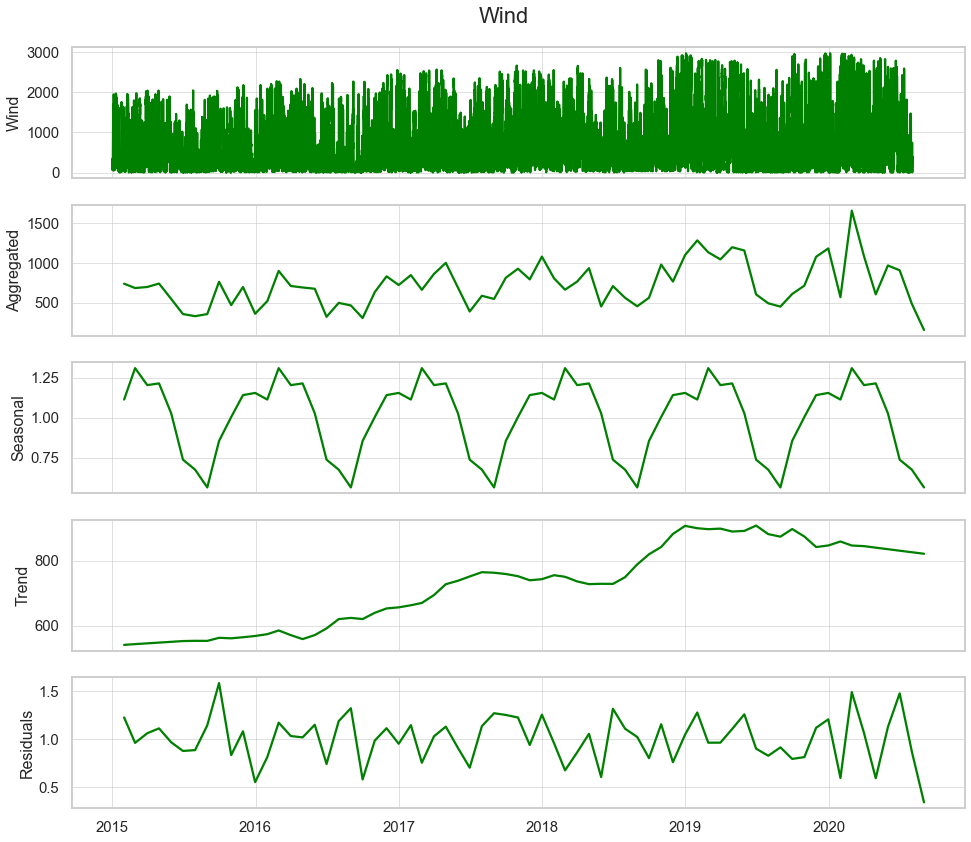

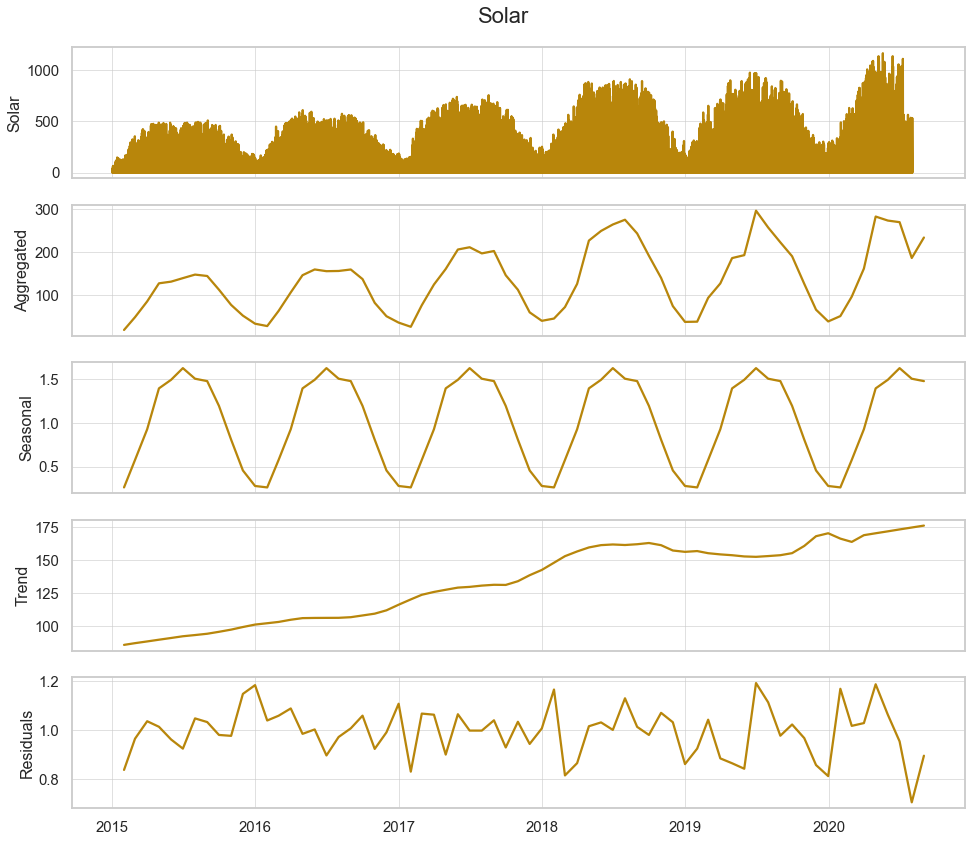

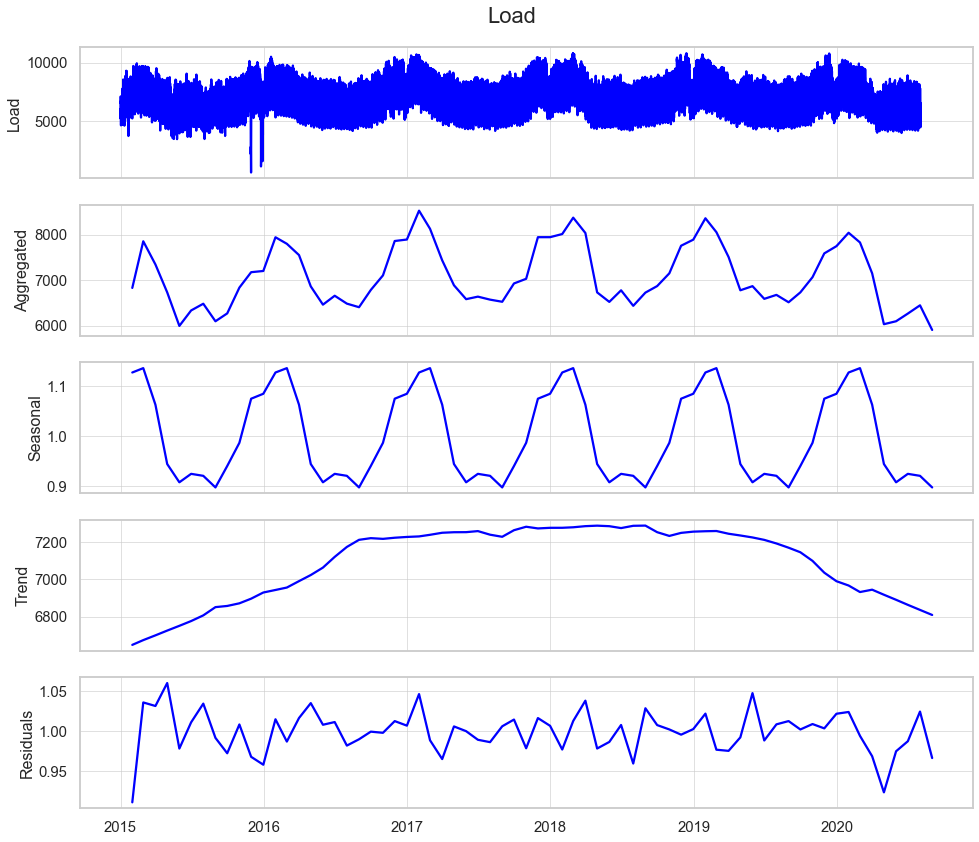

In [18]:
# Decomposition
# NOTE: If zero or negative values then multiplicative shouldn't work
for enum, column in enumerate(data_columns):

    # Resample data to month
    data = df[column].resample(resample).mean()

    try:
        
        # Get trend, seasonal, and residuals
        result = seasonal_decompose(data,
                                    model='multiplicative',
                                    extrapolate_trend=extrapolate_trend)

        results_df = pd.concat(
            [result.seasonal, result.trend, result.resid, result.observed],
            axis=1)
        results_df.columns = ['Seasonal', 'Trend', 'Residuals', 'Aggregated']

        fig, axes = plt.subplots(5,1, figsize=(16, 14), sharex=True)
        plt.suptitle(t=column, size=22, y=0.92)
        
        # Plot original data
        sns.lineplot(
            ax=axes[0],
            data=df[column],
            color=colors[column],
            ci=None,
        )
        
        for enum, col in enumerate(
            ['Aggregated', 'Seasonal', 'Trend', 'Residuals']):

            sns.lineplot(
                ax=axes[enum+1],
                data=results_df[col],
                color=colors[column],
                ci=None,
            )

    except:
        print(
            f"{column}: Multiplicative decomposition not possible -> Negative or zero values!"
        )
        pass

### STL Decomposition

In [ ]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)

# https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/


# Stationarity

## Descprition


A process is **stationary** if, 
- the mean does not change mean over time
- the variance does not change mean over time (homoscedasticity)
- the covariance function does not depend on time, only on the distance between observations

> **Random walk** process is a **non-stationary** time series.

> **White noise** process generated by the standard normal distribution is **stationary**

(https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

**Autocorrelation** is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

**Partial Autocorrelation** also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

https://www.machinelearningplus.com/time-series/time-series-analysis-python/


The partial autocorrelation of lag $k$ of a series is the coefficient of that lag in the autoregression equation of $Y$. The autoregressive equation of $Y$ is nothing but the linear regression of $Y$ with its own lags as predictors.

For Example, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of $Y_t$, then the partial autocorrelation of lag 3 $Y_{t-3}$ is the coefficient $\alpha_3$ of $Y_{t-3}$ in the following equation:$$Y_t = a_0 + a_1 Y_{t-1}+a_2 Y_{t-2}+a_3 Y_{t-3}$$


**Why stationarity is important?**

Linear regression works best if the predictors (X variables) are not correlated against each other. Stationarizing removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

**How to make a time series stationary?**

You can make series stationary by:

- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

## Lag Plots
A Lag plot is a scatter plot of a time series against a lag of itself. 
If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such then the series is likely to be random white noise.
> __Note__: Points get wide and scattered with increasing lag -> lesser correlation

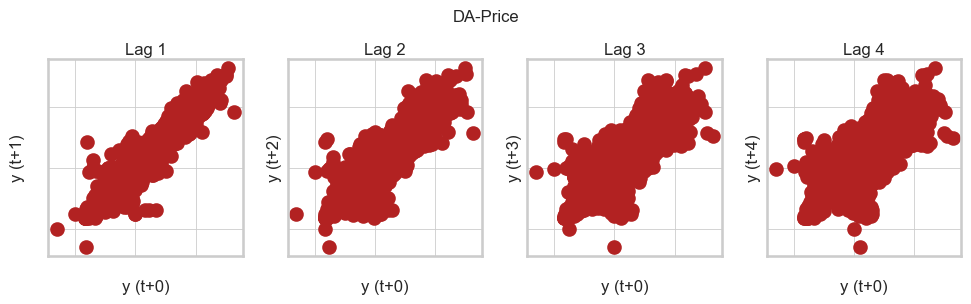

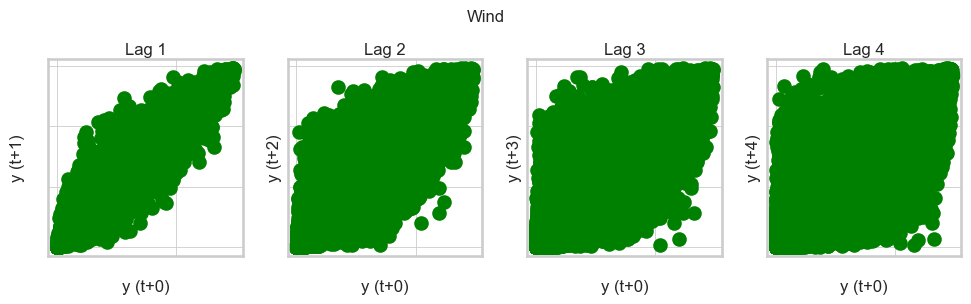

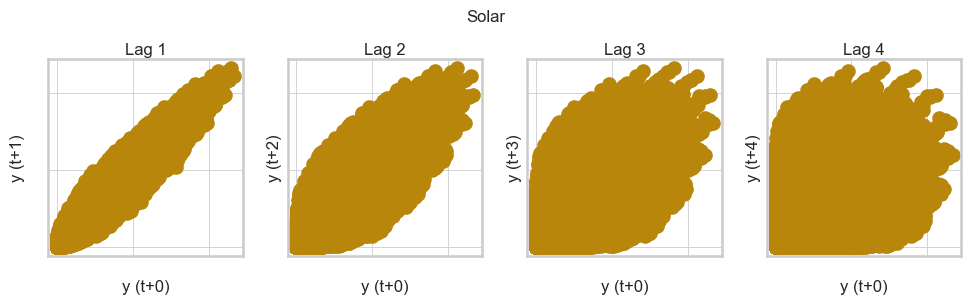

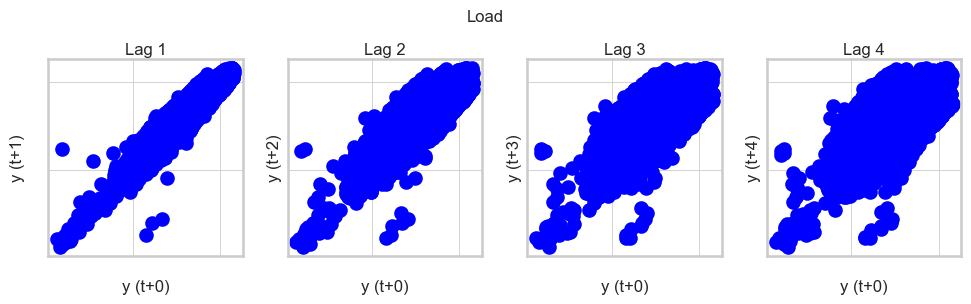

In [32]:
#Lag Plot
for enum, column in enumerate(data_columns):
    fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        pd.plotting.lag_plot(df[column], lag=i+1, ax=ax, c=colors[column])
        ax.set_title('Lag ' + str(i+1), pad=3, size=12)
        ax.axes.labelsize=12
        # Turn off tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_ylabel(f'y (t+{i+1})', size=12)
        ax.set_xlabel('y (t+0)',size=12)
        plt.tight_layout()

    fig.suptitle(f'{column}', size=12, y=1.03)    

## Test ADF: Augmented Dickey Fuller

- H0: Time series possesses a unit root and **is non-stationary**. 
- If P-Value less than the significance level (0.05), reject the null hypothesis.

In [33]:
for enum, column in enumerate(data_columns):
    print("_"*50 + column)
    # ADF Test
    result = adfuller(df[column].values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}\n')
    print(f'p-value: {result[1]}\n')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

__________________________________________________DA-Price
ADF Statistic: -14.14133881150924

p-value: 2.2432839603182167e-26

Critial Values:
   1%, -3.4304837432424535
Critial Values:
   5%, -2.8615991117370583
Critial Values:
   10%, -2.56680146322775
__________________________________________________Wind
ADF Statistic: -21.320227842848126

p-value: 0.0

Critial Values:
   1%, -3.430483726832385
Critial Values:
   5%, -2.861599104484312
Critial Values:
   10%, -2.566801459367324
__________________________________________________Solar
ADF Statistic: -8.398962266402025

p-value: 2.25851084327925e-13

Critial Values:
   1%, -3.4304837405071624
Critial Values:
   5%, -2.8615991105281435
Critial Values:
   10%, -2.5668014625842797
__________________________________________________Load
ADF Statistic: -16.51593260233925

p-value: 2.085301216451853e-29

Critial Values:
   1%, -3.4304837459778565
Critial Values:
   5%, -2.8615991129460223
Critial Values:
   10%, -2.566801463871246


## Test KPSS: Kwiatkowski-Phillips-Schmidt-Shin
- H0: Time series possesses no unit root and trend **is stationary**. 
- If P-Value less than the significance level (0.05), reject the null hypothesis.

In [35]:
# KPSS Test
for enum, column in enumerate(data_columns):
    print("_"*50 + column)
    result = kpss(df[column].values, regression='c')
    print('KPSS Statistic: %f\n' % result[0])
    print('p-value: %f\n' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print()

__________________________________________________DA-Price
KPSS Statistic: 9.119033

p-value: 0.010000

Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739

__________________________________________________Wind
KPSS Statistic: 5.288105

p-value: 0.010000

Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739

__________________________________________________Solar
KPSS Statistic: 10.750955

p-value: 0.010000

Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739

__________________________________________________Load
KPSS Statistic: 1.481026

p-value: 0.010000

Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739



C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages

## Autocorrelation

### Description

- Use AC with original series to detect seaonality
- Use AC of residuals series to see if there is any information last that can be used to improve our forecasts

__Common Patterns__:

>Positive lag-1 AC: **"stickiness"** => High follows High, Low follows Low

>Negative lag-1 AC: **"swings"** => Series "swings" between high and low

>Spikes of multiples of some lags (e.g. 12, 24, 36): **"seasonality"** => Correlation between certain time periods

**NOTE: NO Autocorrelation means there is NO information available to perform forecasts - we can't do better than naive forecast!**

### Autocorelation: DA-PRICE

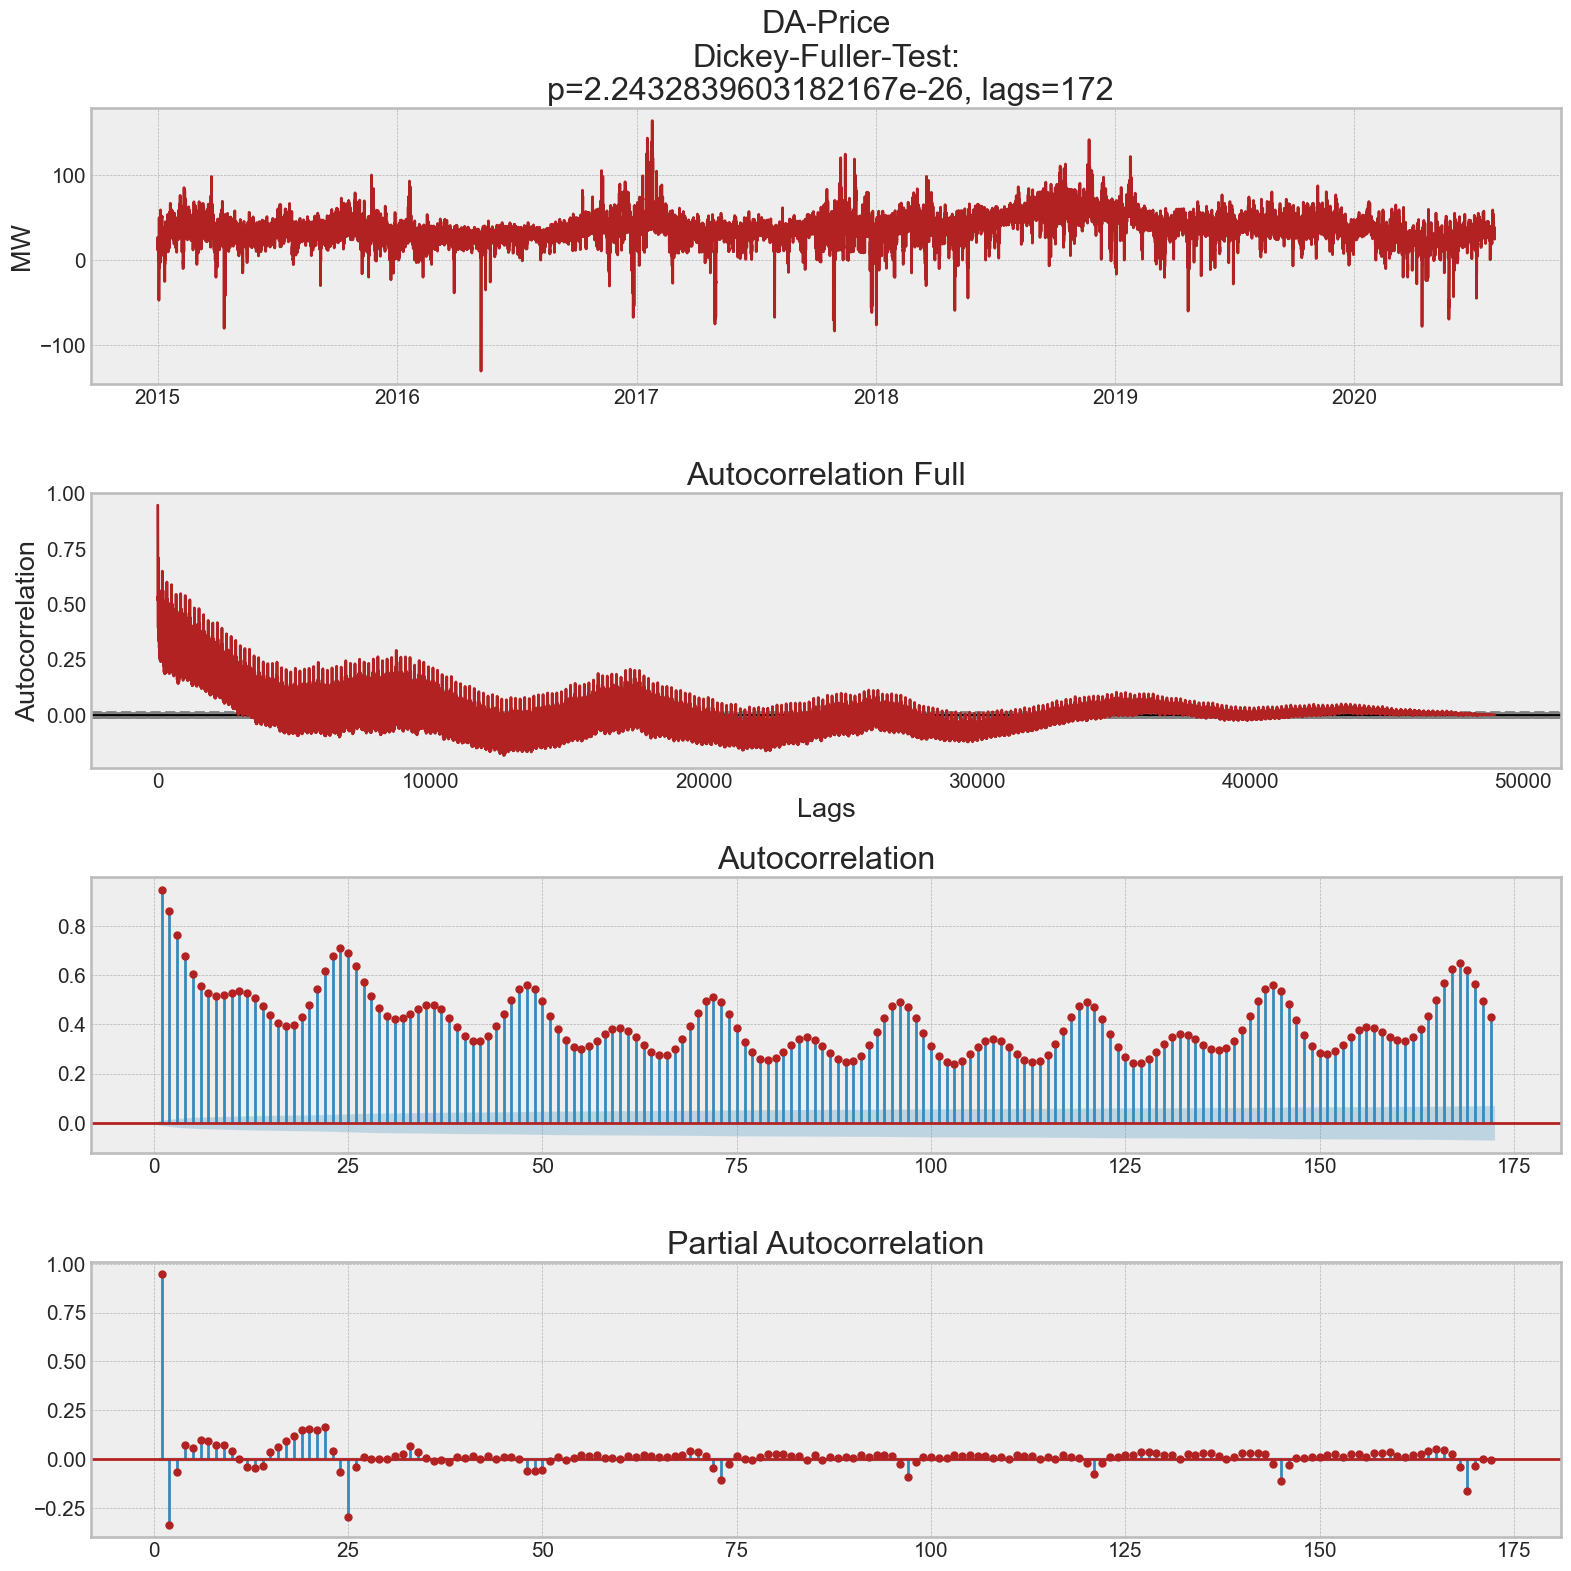

In [89]:
# Autocorrelation
with plt.style.context("bmh"):
    auto_correlation_plot_1(series=df["DA-Price"],
                          color=colors["DA-Price"], lags=172)

### Autocorelation: LOAD

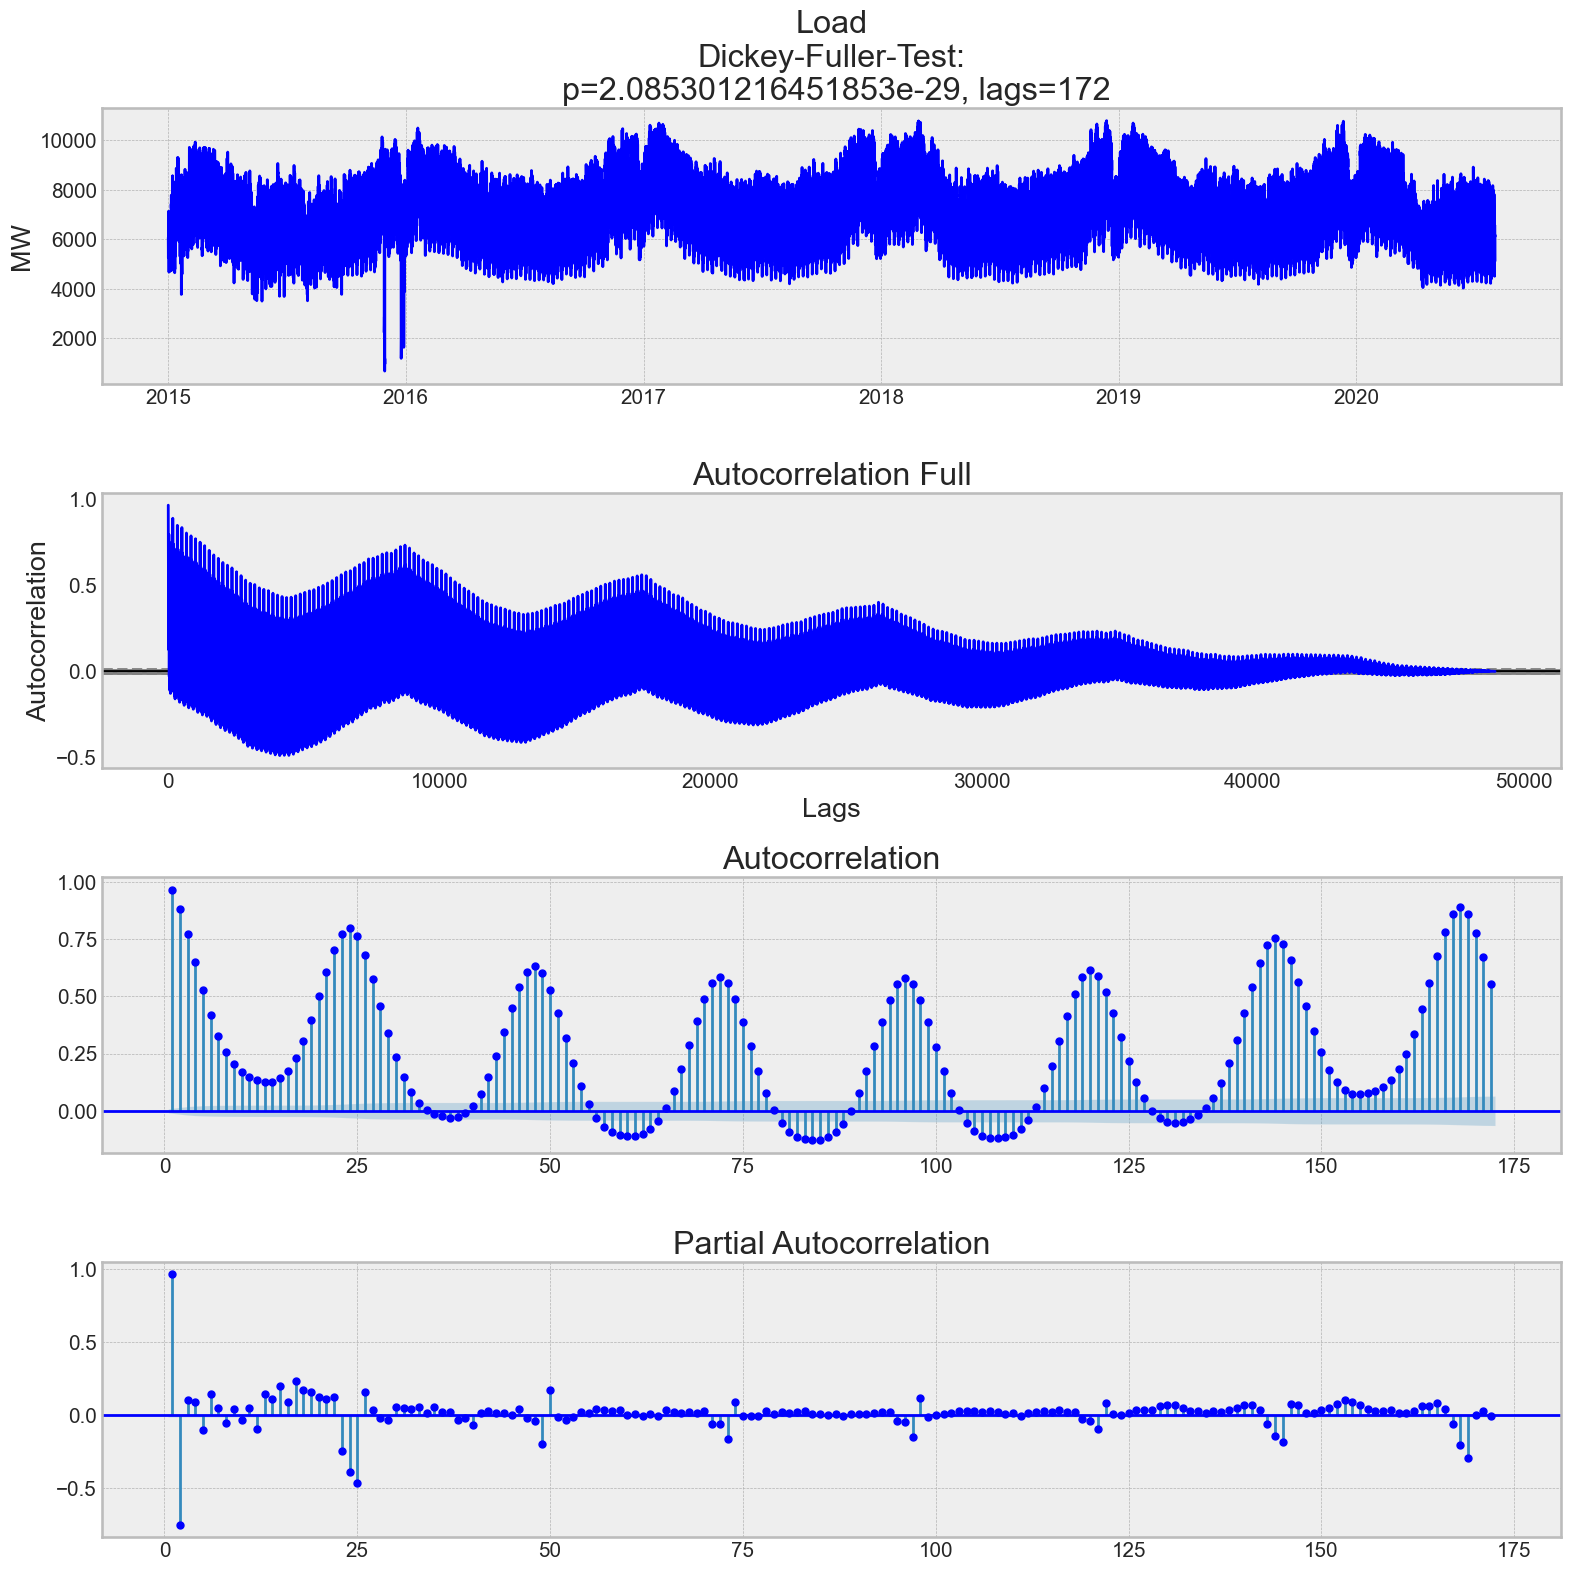

In [90]:
# Autocorrelation
with plt.style.context("bmh"):
    auto_correlation_plot_1(series=df["Load"], color=colors["Load"], lags=172)

### Autocorelation: WIND

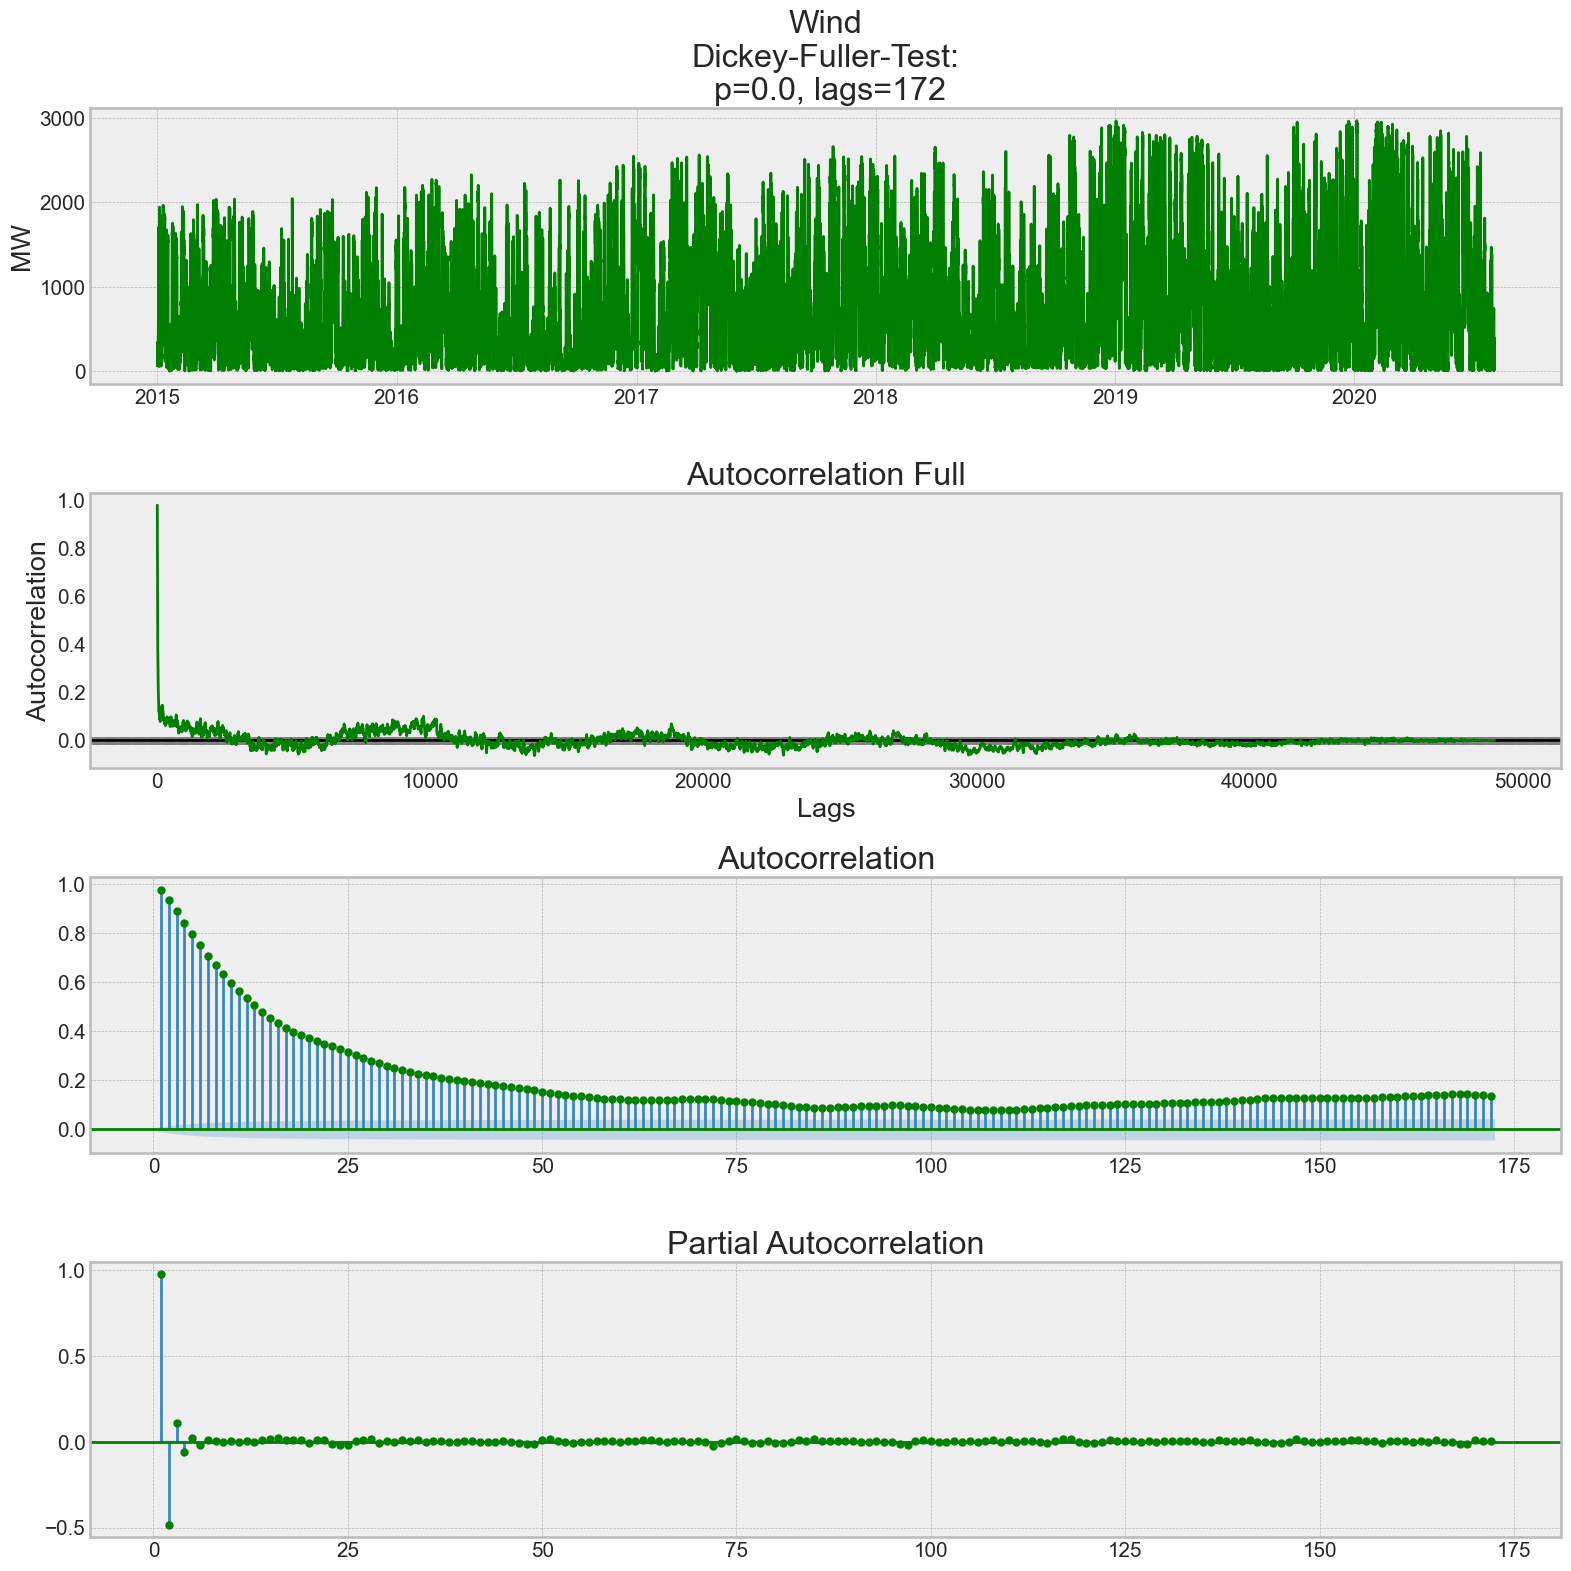

In [91]:
# Autocorrelation
with plt.style.context("bmh"):
    auto_correlation_plot_1(series=df["Wind"], color=colors["Wind"], lags=172)

### Autocorelation: SOLAR

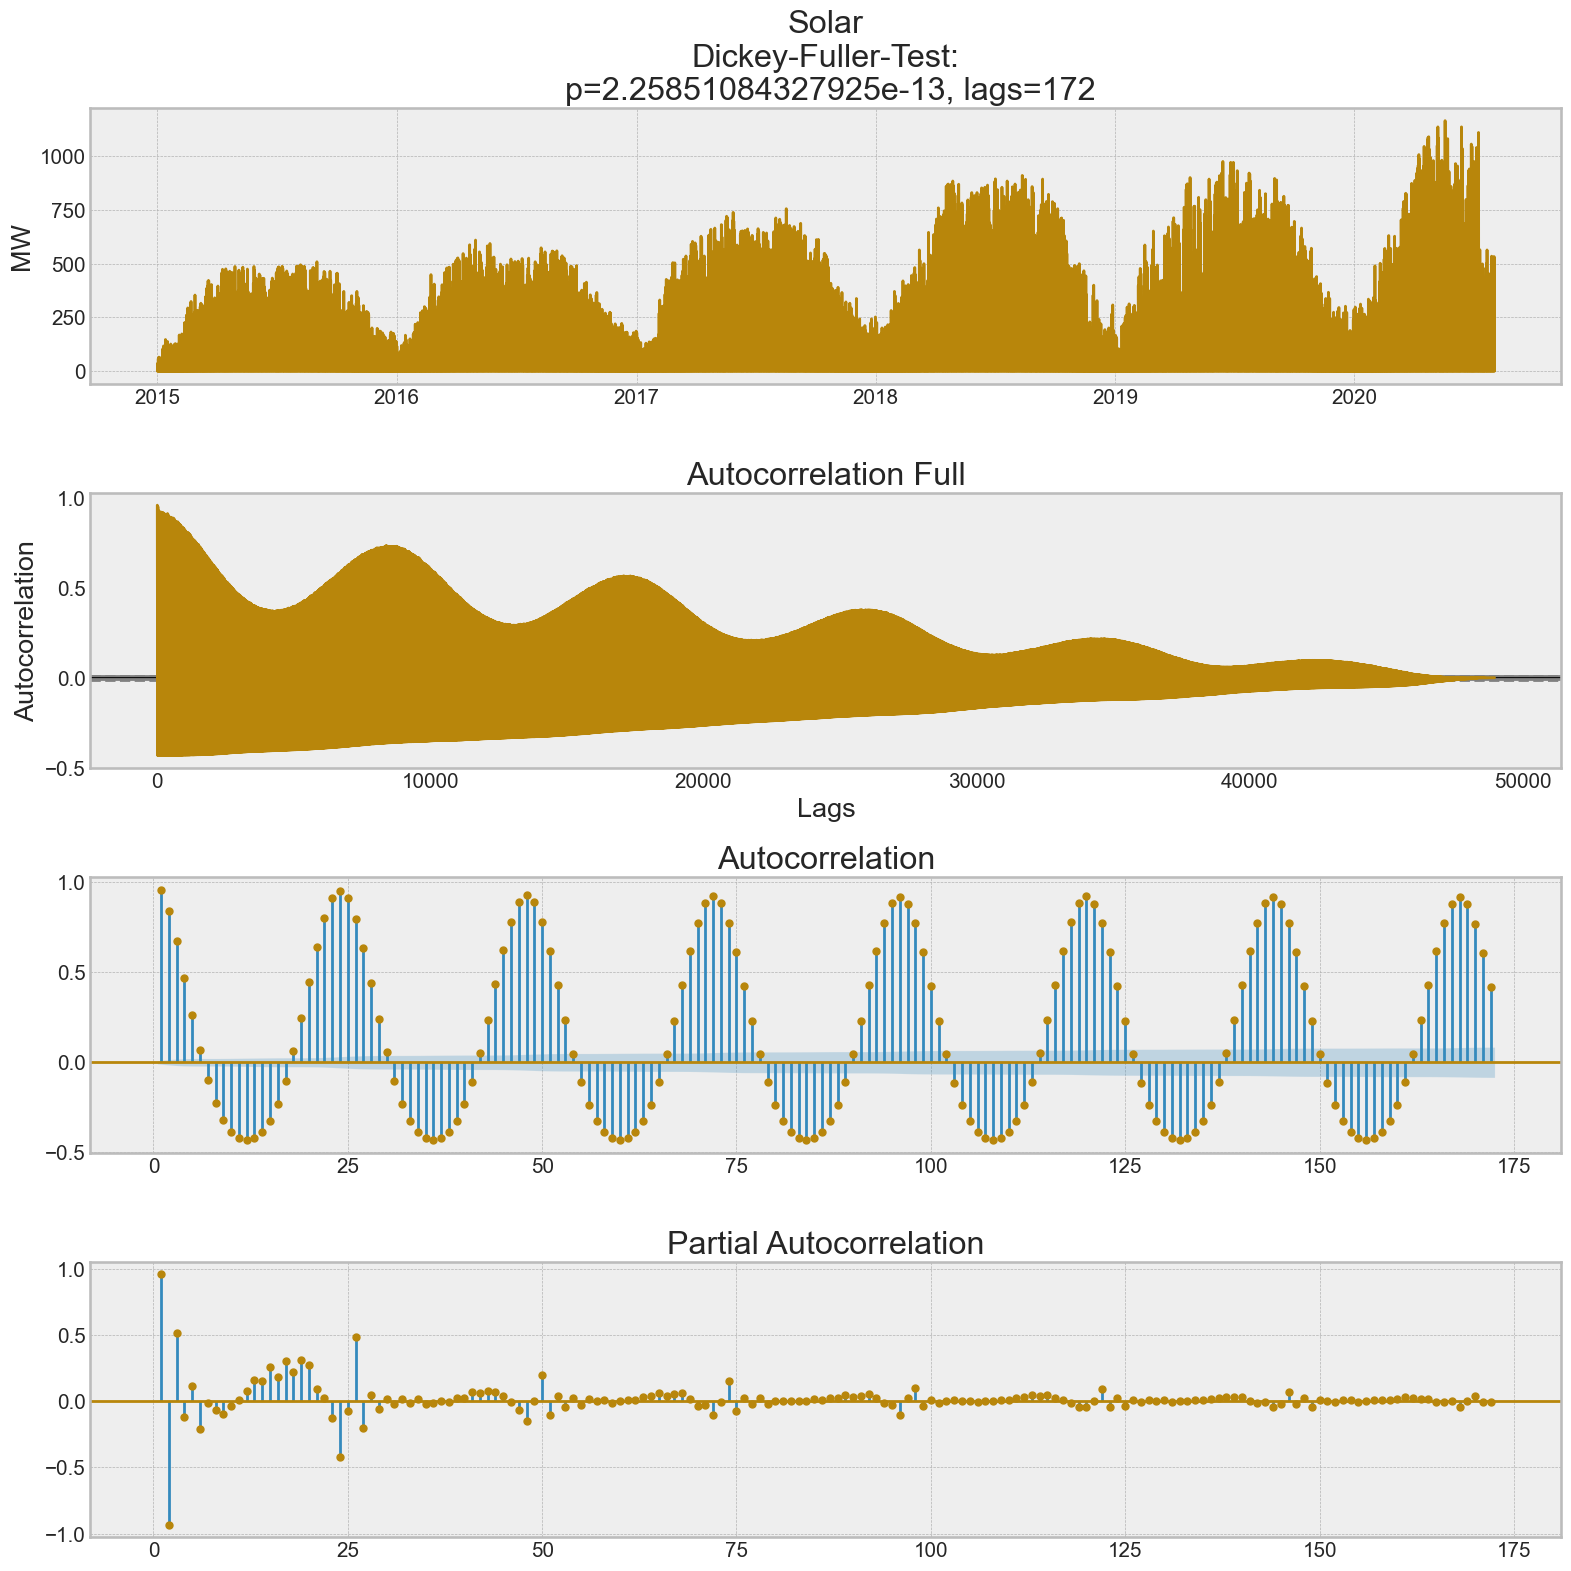

In [92]:
# Autocorrelation
with plt.style.context("bmh"):
    auto_correlation_plot_1(series=df["Solar"], color=colors["Solar"], lags=172)

# Detrend & Deseasonalize *



- Subtract the line of a computed best fit estimation.


- Subtract the trend component obtained from time series decomposition we saw earlier.


- Subtract the mean


- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

## DATA COPY@detrending

In [8]:
df_tc = deepcopy(df)
df_bf = deepcopy(df)

## Detrend: Subtracting Trend Component *

In [9]:
for enum, column in enumerate(data_columns):    
    
    result = seasonal_decompose(df_tc[column], model='additive', extrapolate_trend='freq')
    df_tc[column] = df_tc[column] - result.trend
    

NameError: name 'Plot' is not defined

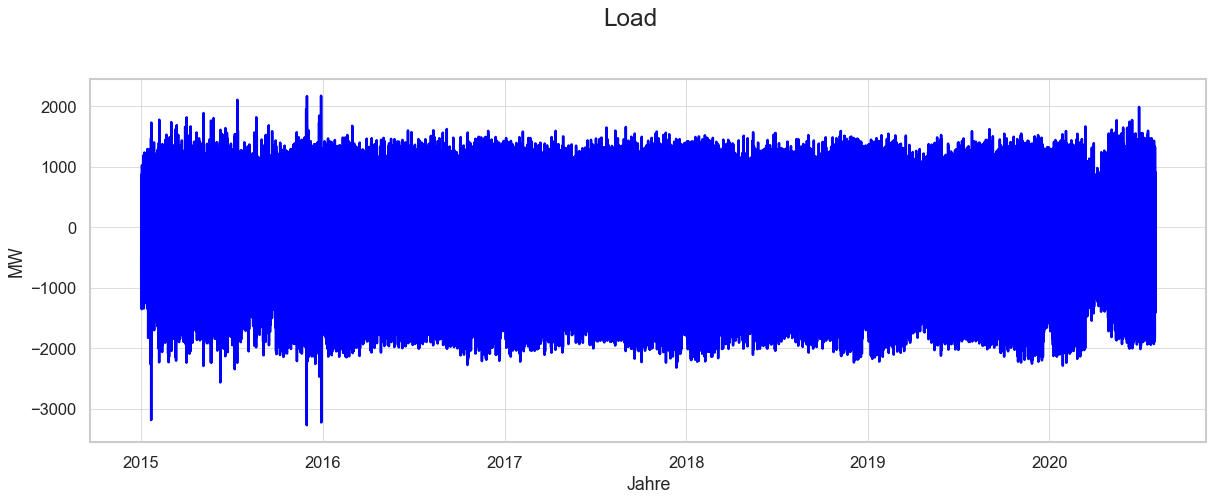

In [11]:
# Detrended Plot
fig = plt.figure(figsize=(18, 6), dpi=80)
ax = sns.lineplot(
    data=df_tc[column],
    x=df.index,
    y=df_tc[column],
    color=colors[column],
)

ax.set(xlabel="Jahre", ylabel=units[column])
plt.suptitle(t=column, size=22, y=1.03)

auto_correlation_plot(df_tc[column], lags=178, color=colors[column])

## Detrend: Best-Fit *

In [12]:
for enum, column in enumerate(data_columns):    
    df_bf[column] = signal.detrend(df_bf[column].values)

In [ ]:
# Detrended Plot
fig = plt.figure(figsize=(18, 6), dpi=80)
ax = sns.lineplot(
    data=_df_bf[column],
    x=df.index,
    y=df_bf[column],
    color=colors[column],
)
ax.set(xlabel="Jahre", ylabel=units[column])
plt.suptitle(t=f"Detrend: BEST FIT\n{column}", size=22, y=1.03)

auto_correlation_plot(df_bf[column], lags=178, color=colors[column])

## Detrend: Comparison

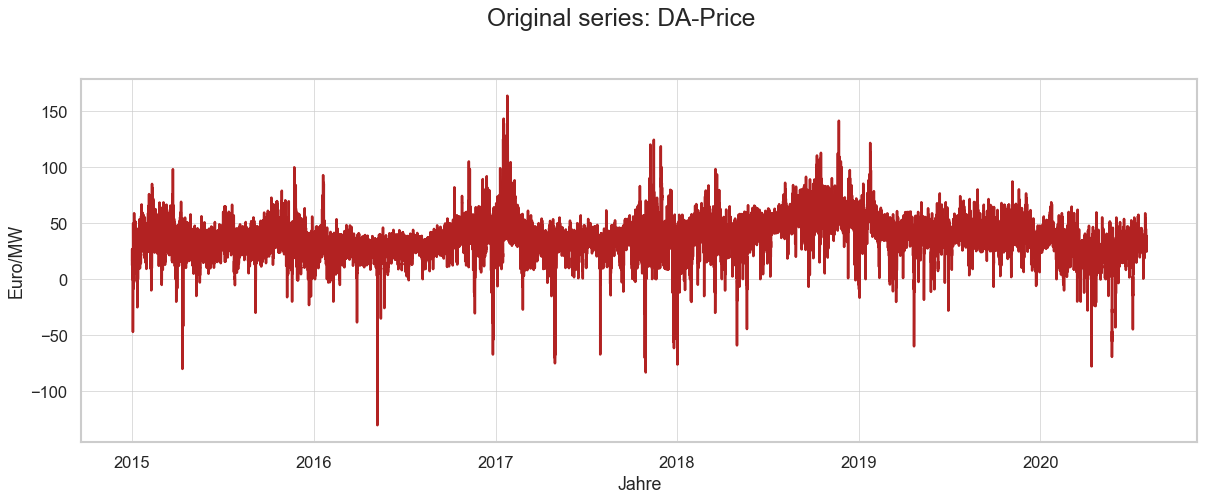

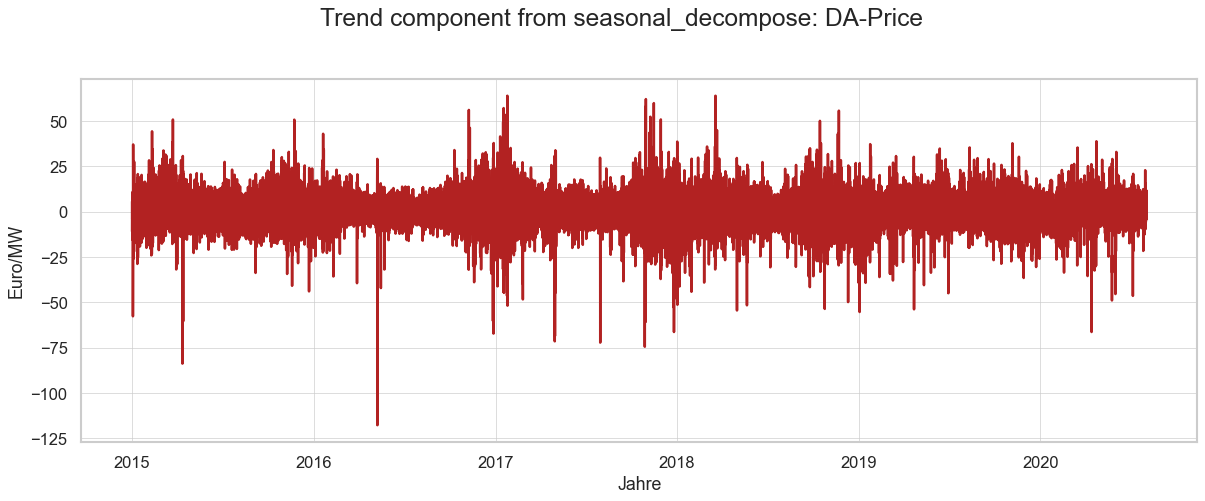

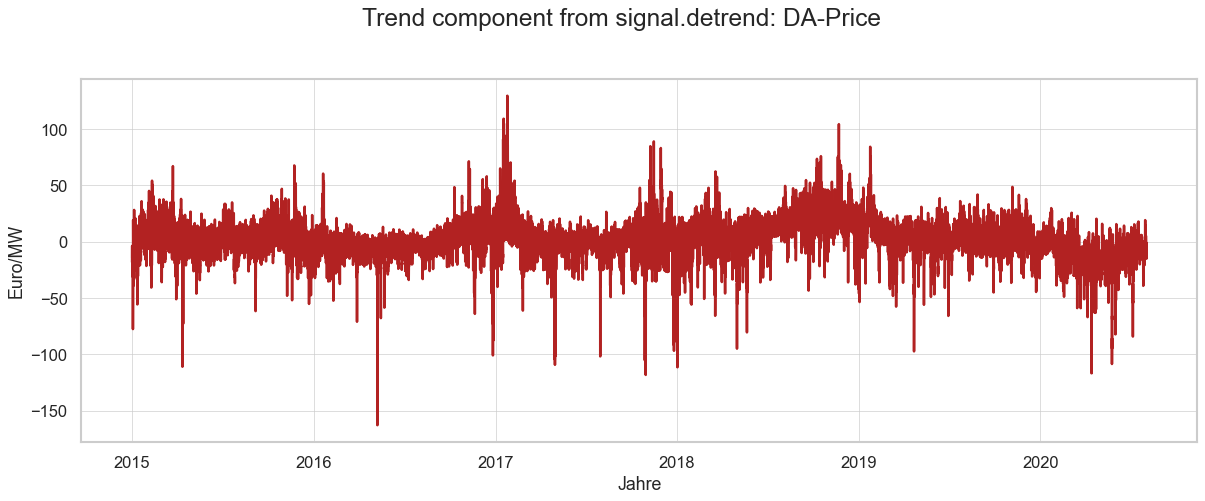

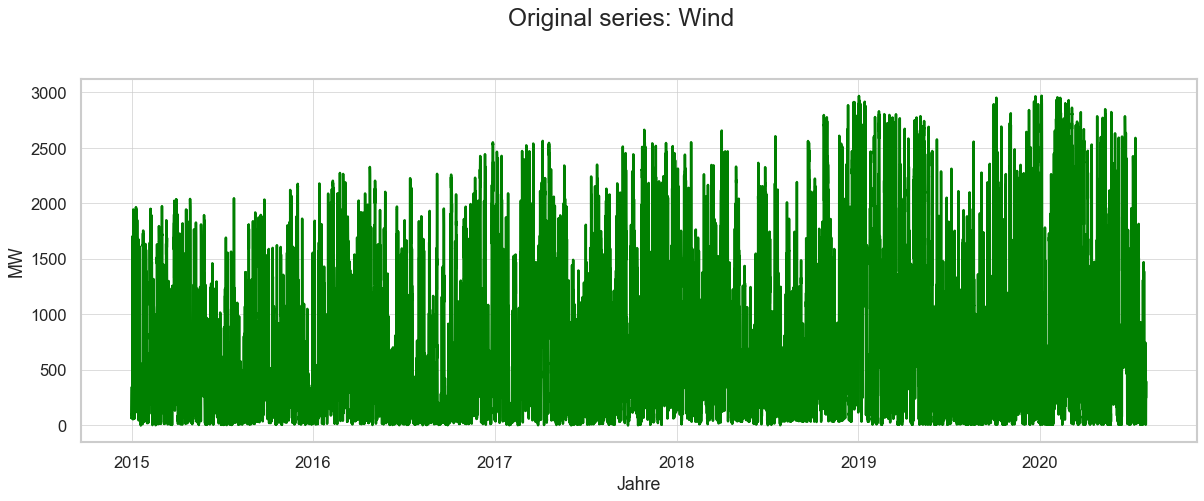

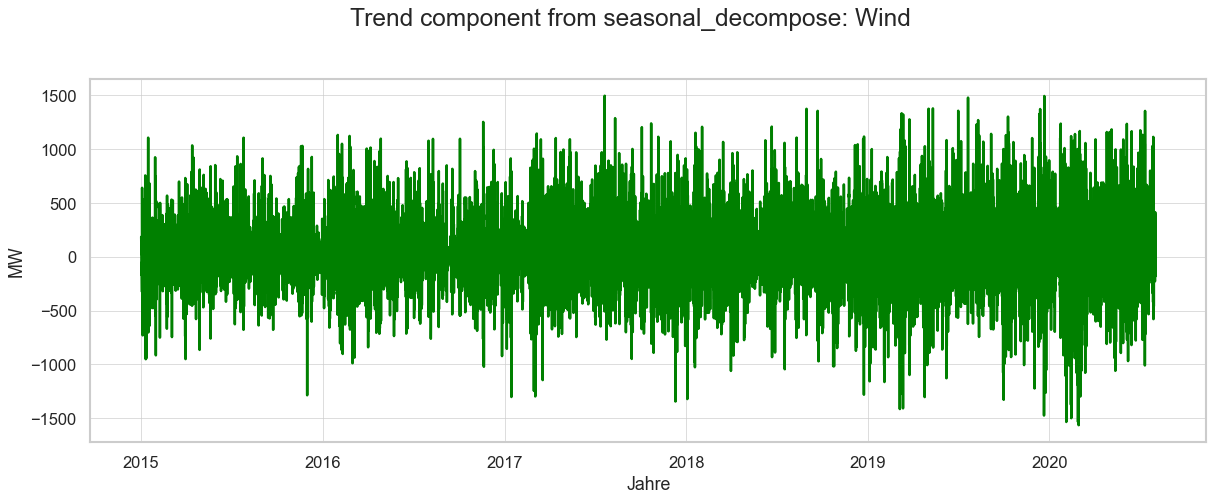

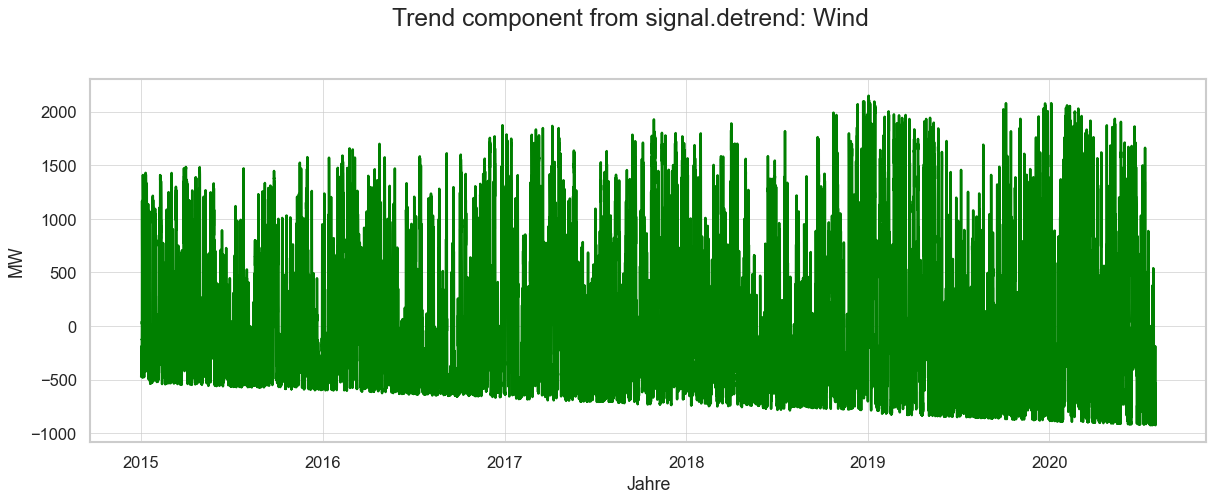

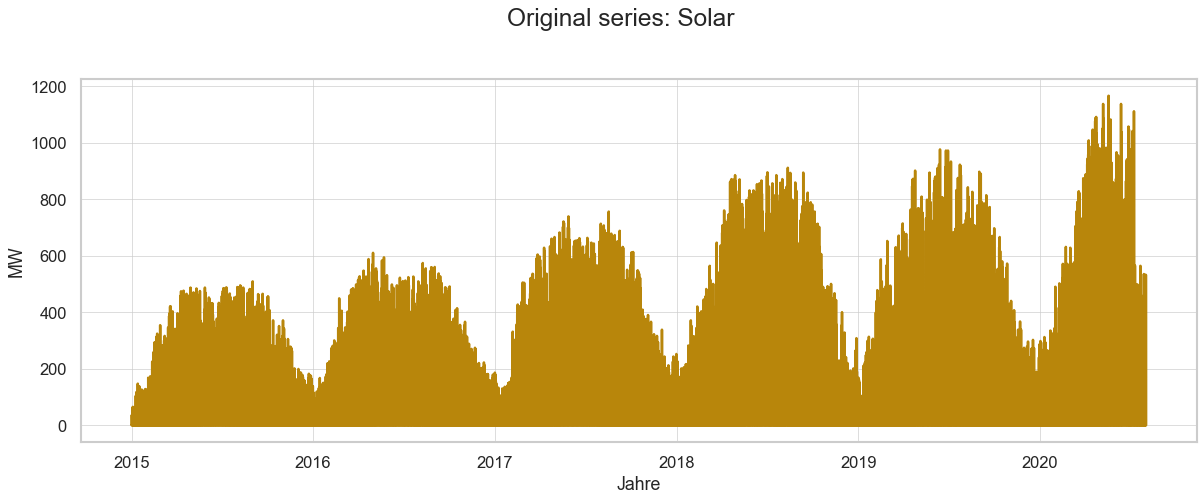

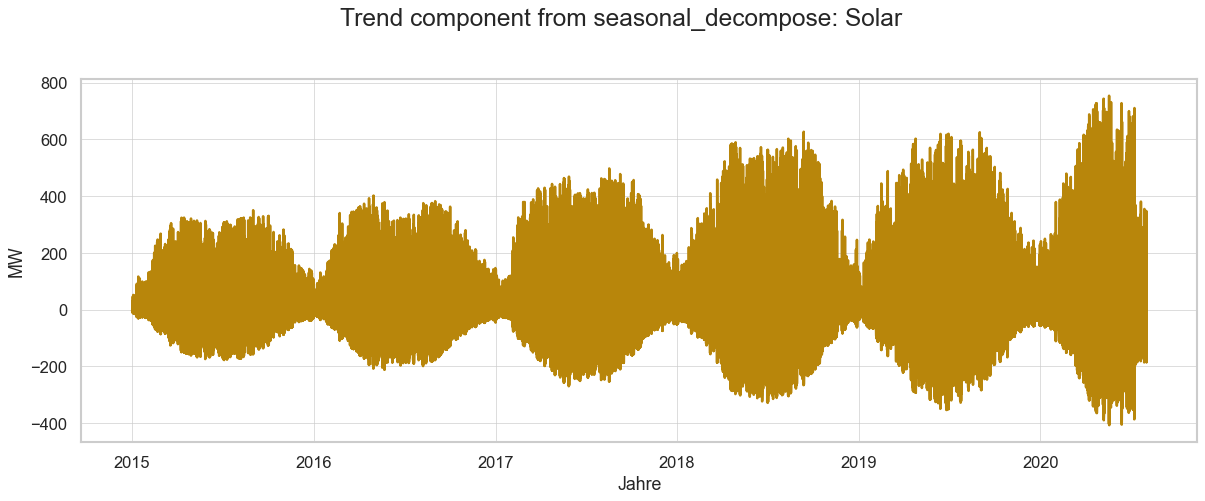

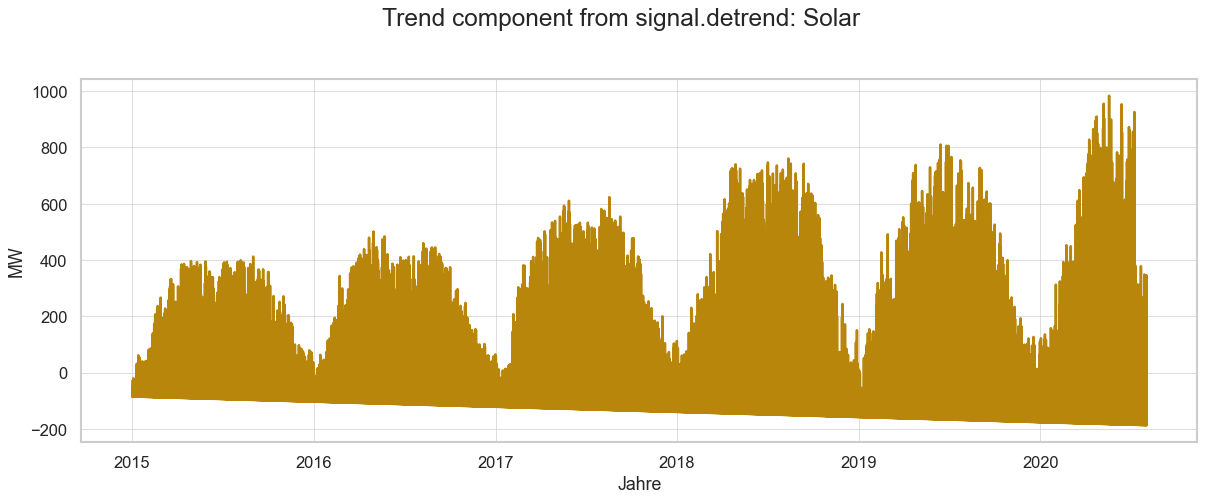

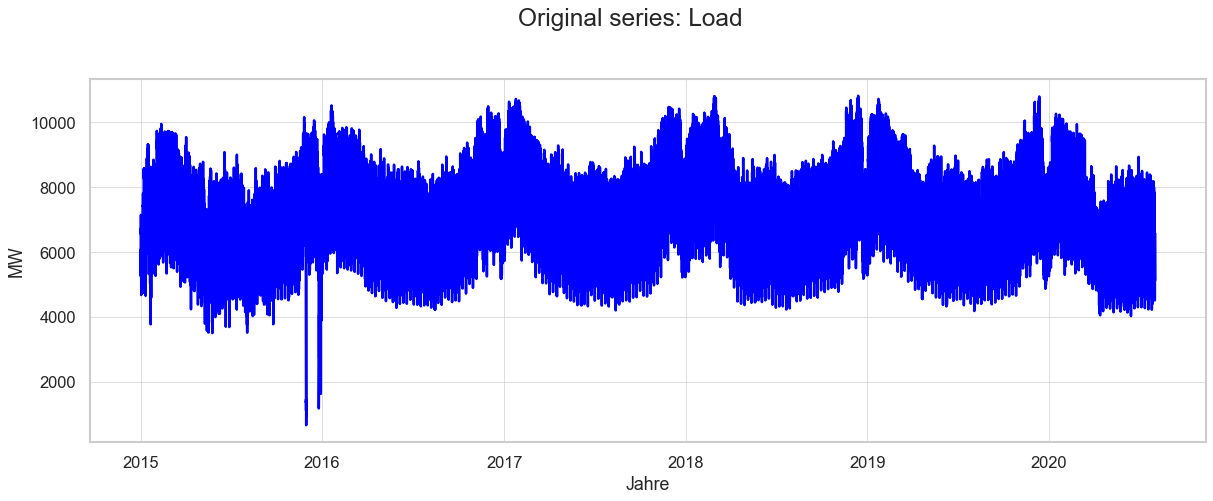

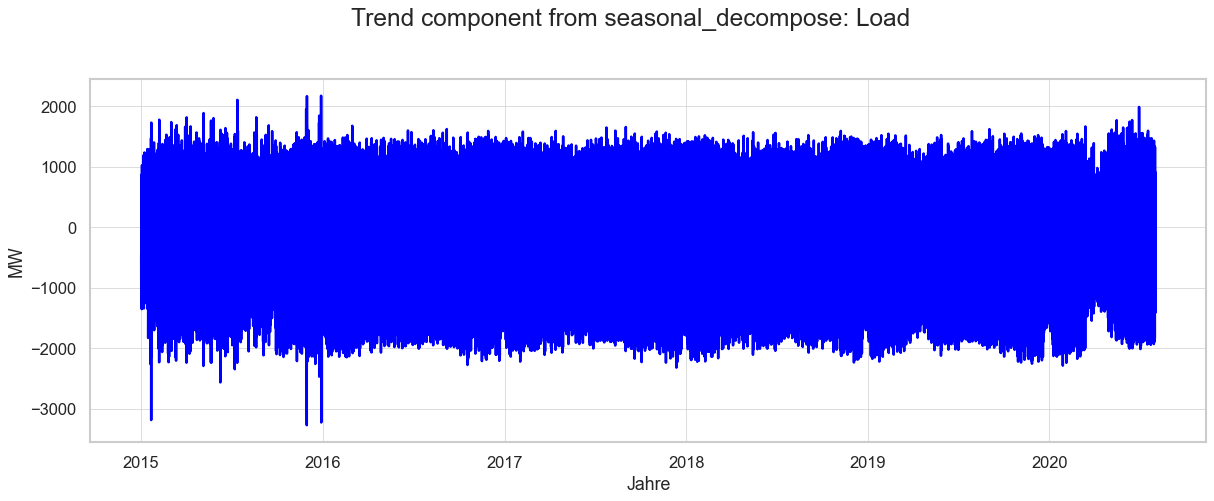

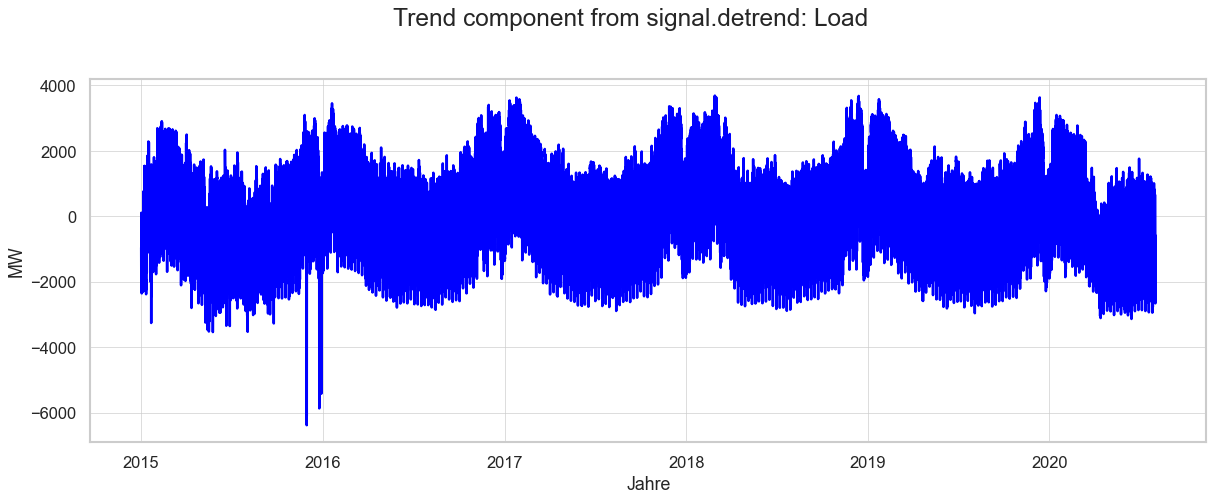

In [17]:
titles = ["Original series", "Trend component from seasonal_decompose", "Trend component from signal.detrend"]
for enum, column in enumerate(data_columns): 
    # Differencing the original df, the trend-component detrended df, and the best-fit detrended df
    for _df, title in zip([df,df_tc,df_bf], titles):
        fig = plt.figure(figsize=(18, 6), dpi=80)
        ax = sns.lineplot(
            data=_df[column],
            x=_df.index,
            y=_df[column],
            color=colors[column],
        )
        ax.set(xlabel="Jahre", ylabel=units[column])
        plt.suptitle(t=f"{title}: {column}", size=22, y=1.03)


## Differencing

### Horizon 24h

In [53]:
df_diff24 = deepcopy(df)
df_tc_diff24 = deepcopy(df_tc)
df_bf_diff24 = deepcopy(df_bf)

# SHIFT 24
interval=24

# Differencing the original df, the trend-component detrended df, and the best-fit detrended df
for _df in [df_diff24,df_tc_diff24,df_bf_diff24]:

    for enum, column in enumerate(data_columns):    

        for _df in [df, _df_tc, _df_bf]

            shifted = _df[data_columns]-_df[data_columns].shift(interval)

            auto_correlation_plot(shifted[column].iloc[interval:], lags=172, color=colors[column])

    #     if enum == 0:
    #         break

SyntaxError: invalid syntax (<ipython-input-53-49e4522d5e4b>, line 7)

### Horizon 1h

In [ ]:
df_diff24 = deepcopy(df)
df_tc_diff24 = deepcopy(df_tc)
df_bf_diff24 = deepcopy(df_bf)

# SHIFT 1
interval=1

# Differencing the original df, the trend-component detrended df, and the best-fit detrended df
for _df in [df_diff24,df_tc_diff24,df_bf_diff24]:

    
    # Differencing the original df, the trend-component detrended df, and the best-fit detrended df
    for _df in [df, _df_tc, _df_bf]
        
        shifted = _df[data_columns]-_df[data_columns].shift(interval)
        
        auto_correlation_plot(shifted[column].iloc[interval:], lags=172, color=colors[column])

#     if enum == 0:
#         break

In [608]:
shifted_df

DA-Price   Wind  Solar   Load
2015-01-01 01:00:00       NaN    NaN    NaN    NaN
2015-01-01 02:00:00       NaN    NaN    NaN    NaN
2015-01-01 03:00:00       NaN    NaN    NaN    NaN
2015-01-01 04:00:00       NaN    NaN    NaN    NaN
2015-01-01 05:00:00       NaN    NaN    NaN    NaN
...                       ...    ...    ...    ...
2020-08-01 14:00:00     -6.58 -249.0    0.0 -904.0
2020-08-01 15:00:00     -6.13 -278.0    0.0 -708.0
2020-08-01 16:00:00     -7.46 -347.0    0.0 -626.0
2020-08-01 17:00:00     -4.58 -266.0    0.0 -479.0
2020-08-01 18:00:00      1.68  -64.0    0.0 -416.0

[48954 rows x 4 columns]

# Models *

## DATA COPY @ Training/Test

In [ ]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [34]:
# Train and Test
_df = deepcopy(df)

train_start = '2015-01-01 00:00:00'
# train_end = '2019-12-31 23:00:00'
train_end = '2020-01-31 23:00:00'
test_start = '2020-02-01 00:00:00'
test_end = '2020-02-28 18:00:00'
train = _df.loc[train_start:train_end].dropna()
test = _df.loc[test_start:test_end].dropna()

### Plot: TRAINING & TEST

<AxesSubplot:title={'center':'Test'}>

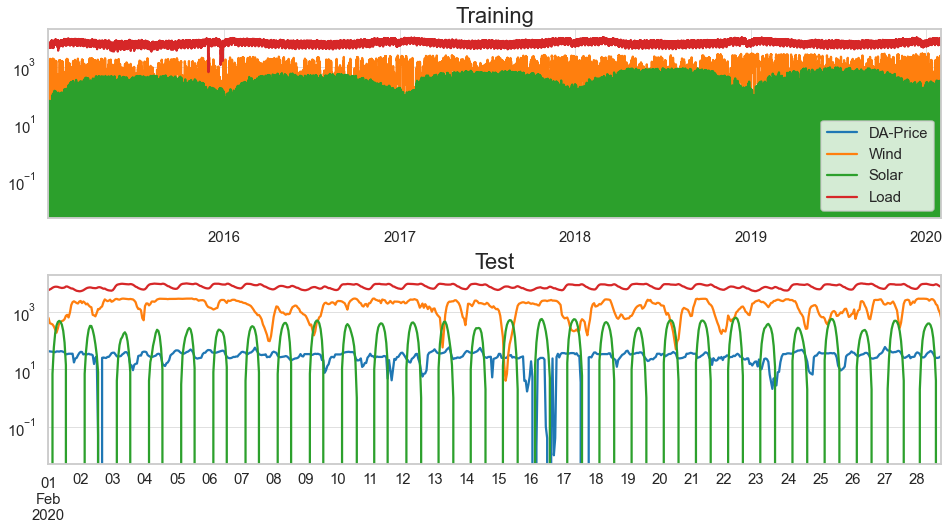

In [35]:
# Plots Train and Test
fig, axs = plt.subplots(2,
                        1,
                        figsize=(16, 8),
                        gridspec_kw={
                            'hspace': 0.3,
                            'wspace': 0
                        })

train[data_columns].plot(legend=True, ax=axs[0], title="Training", logy=True)
test[data_columns].plot(legend=False, ax=axs[1], title="Test", logy=True)

### Autocorrelation: ORIGINAL

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 Original Data Series
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 Training 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


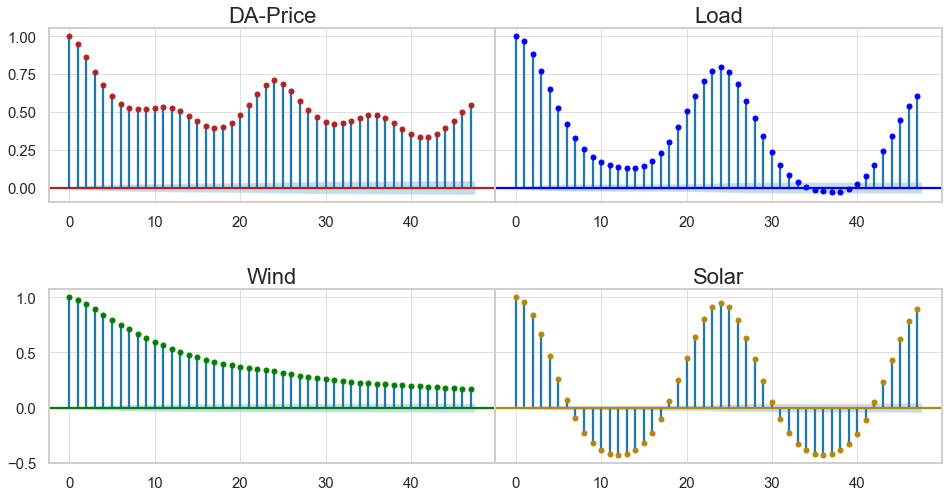

In [216]:
#Autocorrelation: ORIGINAL
print("/"*127+ "\n Original Data Series\n" + "/"*127)
auto_correlation_plot_2(df)

### Autocorrelation: TRAINING

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 TRAINING 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


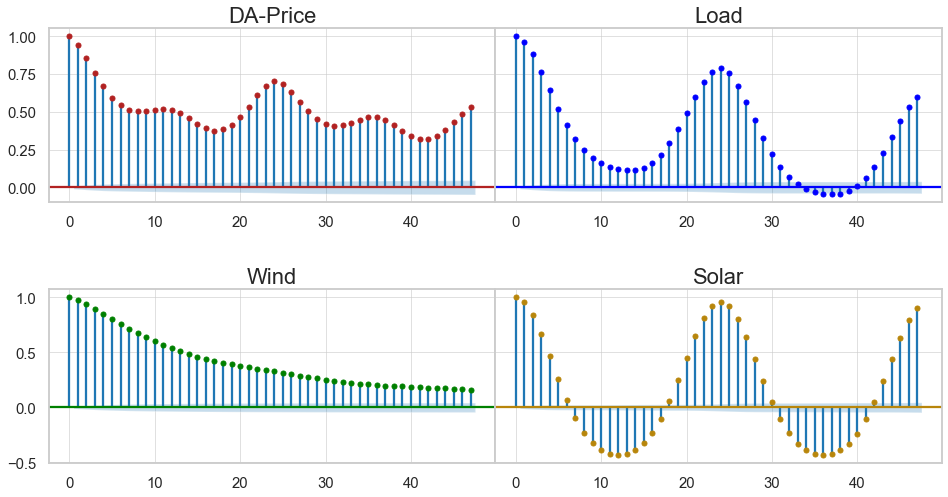

In [219]:
#Autocorrelation: TRAINING
print("/"*127+ "\n TRAINING \n" + "/"*127)
auto_correlation_plot_2(train)

### Autocorrelation: TEST

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 Training 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


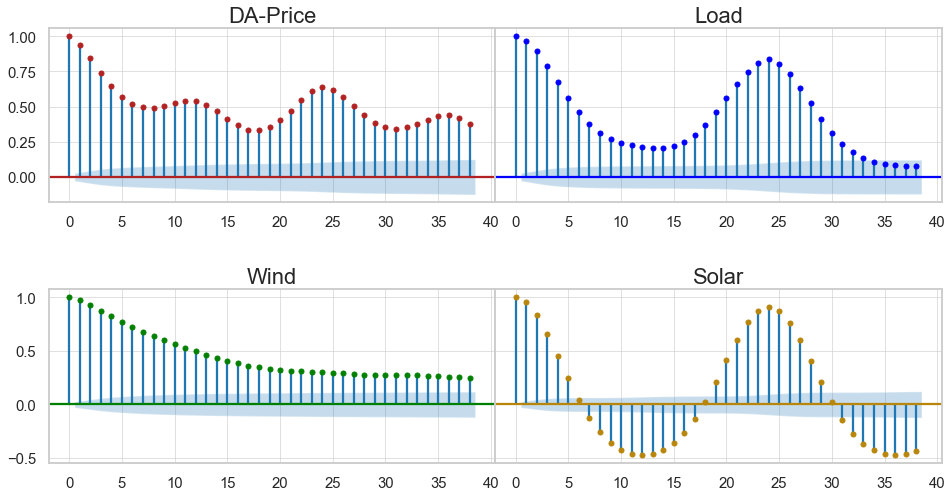

In [173]:
#Autocorrelation: TEST
auto_correlation_plot_2(test)

## Naive

## ARIMA (p,d,q)(P,D,Q)

### ARIMA Description

Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

ARIMA-family Crash-Course
*SARIMA*($p$,$d$,$q$)($P$,$D$,$Q$,$s$) , Seasonal Autoregression Moving Average model:

**AR($p$)**  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p . To determine the initial  $p$, you need to look at the *PACF* plot and find the biggest significant lag after which most other lags become insignificant.

**MA($q$)**  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  $q$. The initial value can be found on the *ACF* plot with the same logic as before.
Let's combine our first 4 letters:

**AR($p$)**+**MA**($q$)=**ARMA**($p$,$q$) 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

__$I$($d$)__  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the *ARIMA* model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

__$S$($s$)__  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  ($P$,$D$,$Q$) 

__P__  - order of autoregression for the seasonal component of the model, which can be derived from *PACF*. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P  should be 2.

__Q__  - similar logic using the *ACF* plot instead.

__D__  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

_______________________________________________________________________________________________________________________________

Source: https://www.youtube.com/watch?v=QDrmpphIfLE
**Keep it simple as simple as possible, differencing at most 1 time!**: 

> "In most cases either p is zero or q is zero, and p+q is less than or equal to 3"

e.g. $d,D={0,1}$, 
small $p$, 
$q$, $P,Q=0,1$

Differencing Lag-12 (Trend) then Lag-1 (Seasonality) is equal to **ARIMA**$(p,1,q)(P,12,Q)$
_______________________________________________________________________________________________________________________________
Source: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

$p$: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.

$d$: The degree of differencing.

$q$: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

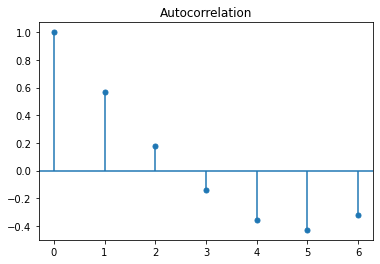

In [1]:
# Autocorrelation EXAMPLE
x = pm.c(1, 2, 3, 4, 5, 6, 7)

# Compute an auto-correlation like you would in R:
pm.acf(x)

# Plot an auto-correlation:
pm.plot_acf(x)

### TEST: Should we difference the series?

In [58]:
# Test ADF: Train and Test data

print("\n Test whether we to difference at alpha=0.05 significance level")

for df, data in zip([df, train, test], ["full", "train", "test"]):

    print("/"*100 + "\n"+ data + "\n" + "/"*100)
    
    for enum, column in enumerate(data_columns):

        res = sm.tsa.adfuller(_df[column].dropna(), regression='ct')
        
        adf_test = ADFTest(alpha=0.05)
        
        p_val, should_diff = adf_test.should_diff(_df[column])  # (0.01, False)

        print("_"*100)
        print(column)
        print('\tShould we differencing the series? \t{}'.format(should_diff))        
        print("_"*100)
        print(f"\tADF(sm.tsa):\tp-value:{res[1]}\n\tADF(pm):\tp-value:{p_val}\n")



Test whether we to difference at alpha=0.05 significance level
////////////////////////////////////////////////////////////////////////////////////////////////////
full
////////////////////////////////////////////////////////////////////////////////////////////////////
____________________________________________________________________________________________________
DA-Price
	Should we differencing the series? 	False
____________________________________________________________________________________________________
	ADF(sm.tsa):	p-value:4.588056322221828e-22
	ADF(pm):0.01
____________________________________________________________________________________________________
Wind
	Should we differencing the series? 	False
____________________________________________________________________________________________________
	ADF(sm.tsa):	p-value:0.0
	ADF(pm):0.01
____________________________________________________________________________________________________
Solar
	Should we differenc

### TEST: Estimate number of the trend differences term d

In [198]:
# ARIMA(d): Estimate the number of differences 

for df, data in zip([df, train, test], ["full", "train", "test"]):

    print("/"*127 + f"\n {data} \n" + "/"*127)

    for enum, column in enumerate(data_columns):
        
        # Using an ADF test:
        n_adf = ndiffs(train[column], test='adf')  # -> 0

        # Or a KPSS test (auto_arima default):
        n_kpss = ndiffs(train[column], test='kpss')  # -> 0

        # Or a PP test:
        n_pp = ndiffs(train[column], test='pp')  # -> 0
        
    #     assert n_adf == n_kpss == n_pp == 0

        print(f"{column}:\t\tEstimated value for parameter d:\t adf:{n_adf}\t kpss:{n_kpss}\t pp:{n_pp}")
    print()


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 full 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
DA-Price:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Wind:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Solar:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Load:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 train 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
DA-Price:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Wind:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Solar:		Estimated value for parameter d:	 adf:0	 kpss:1	 pp:0
Load:		Estimated value for paramete

### TEST: Canova-Hansen test to estimate our seasonal differencing term D

#### Description

Source:https://alkaline-ml.com/pmdarima/tips_and_tricks.html

The $m$ parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, $m$ will correspond to some recurrent periodicity such as:

- 7 - daily
- 12 - monthly
- 52 - weekly

Depending on how it’s set, it can **amatically** impact the outcome of an ARIMA model.

#### PARAMETER m

In [257]:
# PARAMETER m: Relates to the number of observations per seasonal cycle, 
m=24
max_D=24

In [210]:
# Canova-Hansen test to estimate seasonal differencing term
for _df, data in zip([df, train, test], ["Original", "Training", "Test"]):

    print("/"*127 + f"\n {data} \n" + "/"*127)
        
    for enum, column in enumerate(data_columns):

        D = nsdiffs(_df[column],
                    m=24,  # commonly requires knowledge of dataset
                    max_D=24,
                    test='ch')  # -> 0

        # or use the OCSB test (by default)
        _D = nsdiffs(df[column],
                m=12,
                max_D=12,
                test='ocsb')  # -> 0
    
        print(f"\tEstimated value for parameter D:\t Canova-Hansen test:{D}\t\t OCSB:{_D}\t")
    print()

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 Original 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
 Training 
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Estimated value for parameter D:	 Canova-Hansen test:1		 OCSB:0	
	Es

### TEST NOT WORKING: Arma-order select IC

In [ ]:
#TEST NOT WORKING: Arma-order select IC
for _df, data in zip([df, train, test], ["Original", "Training", "Test"]):

    print("/"*127 + f"\n {data} \n" + "/"*127)
        
    for enum, column in enumerate(data_columns):

        resDiff = sm.tsa.arma_order_select_ic(_df[column], max_ar=2, max_ma=2, ic='aic', trend='c')
        print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

### TEST NOT WORKING: Stepwise Auto-ARIMA

#### Auto Arima

Source: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

The auto_arima function can be daunting. There are a lot of parameters to tune, and the outcome is heavily dependent on a number of them. In this section, we lay out several considerations you’ll want to make when you fit your ARIMA models.

The parameters p and q can be iteratively searched-for with the auto_arima function, but the differencing term, d, requires a special set of tests of stationarity to estimate.

An integrative term, d, is typically only used in the case of non-stationary data. Stationarity in a time series indicates that a series’ statistical attributes, such as mean, variance, etc., are constant over time (i.e., it exhibits low heteroskedasticity).

A stationary time series is far more easy to learn and forecast from. With the d parameter, you can force the ARIMA model to adjust for non-stationarity on its own, without having to worry about doing so manually.

The value of d determines the number of periods to lag the response prior to computing differences. E.g.,

In [23]:
for enum, column in enumerate([data_columns[0]]):

    stepwise_fit = pm.auto_arima(df[column], start_p=1, start_q=1,
                                 max_p=2, max_q=2, m=12,
                                 start_P=0, seasonal=True,
                                 d=1, D=1, trace=True,
                                 error_action='ignore',  # don't want to know if an order does not work
                                 suppress_warnings=True,  # don't want convergence warnings
                                 stepwise=True)  # set to stepwise
    print(stepwise_fit)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=38.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=329047.941, Time=1.82 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=295715.113, Time=19.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=28.62 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=326742.326, Time=2.51 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=293532.176, Time=68.97 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=137.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=44.17 sec


MemoryError: Unable to allocate 511. MiB for an array with shape (37, 37, 48954) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 964, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: ((37, 37, 48954), dtype('float64'))


AttributeError: Memoryview is not initialized

Index(['DA-Price', 'Wind', 'Solar', 'Load'], dtype='object')

## ARIMA_MODEL_01

### TEST: Autocorrelation Diff lag(24) +  Diff lag(1)

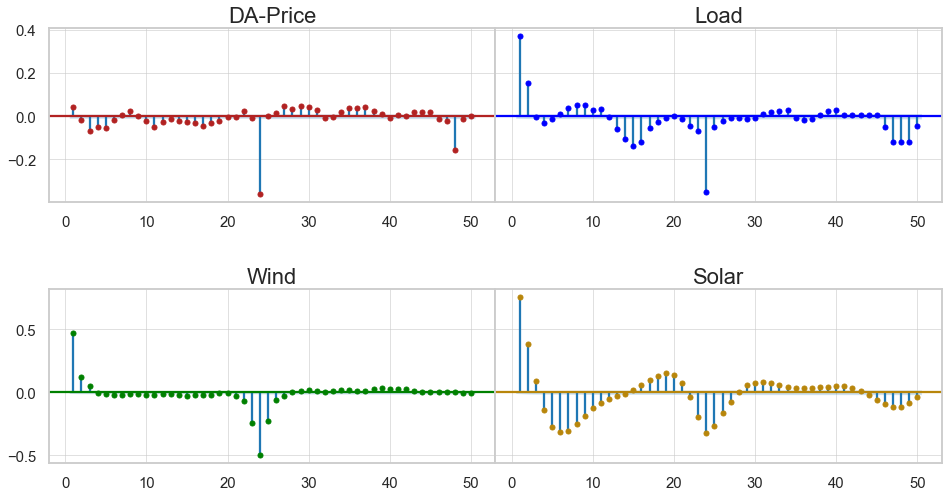

In [36]:
# TEST: Autocorrelation Diff lag(24) +  Diff lag(1)
t = train[data_columns].diff(24).dropna()
t = t.diff(1).dropna()
auto_correlation_plot_2(t)

In [52]:
# Get trend, seasonal, and residuals
decomp = seasonal_decompose(train["Load"],
                            model='multiplicative',
                            extrapolate_trend="freq")


In [53]:
decomp = pd.concat(
    [decomp.seasonal, decomp.trend, decomp.resid, decomp.observed],
    axis=1)
decomp.columns = ['Seasonal', 'Trend', 'Residuals', 'Aggregated']

# res = res.resample("H").mean().ffill()

Seasonal        Trend  Residuals  Aggregated
2015-01-01 01:00:00  0.800491  6534.781842   1.160000      6068.0
2015-01-01 02:00:00  0.825290  6515.428019   1.108958      5963.0
2015-01-01 03:00:00  0.875125  6496.074197   1.007234      5726.0
2015-01-01 04:00:00  0.939610  6476.720374   0.878469      5346.0
2015-01-01 05:00:00  1.007303  6457.366552   0.806977      5249.0
...                       ...          ...        ...         ...
2020-01-31 19:00:00  0.995554  7960.242029   0.855789      6782.0
2020-01-31 20:00:00  0.948927  7943.798551   0.849552      6404.0
2020-01-31 21:00:00  0.901845  7927.355072   0.847362      6058.0
2020-01-31 22:00:00  0.862288  7910.911594   0.861836      5879.0
2020-01-31 23:00:00  0.826092  7894.468116   0.879084      5733.0

[44567 rows x 4 columns]

### TEST: Autocorrelation Diff lag(1) +  Diff lag(24)

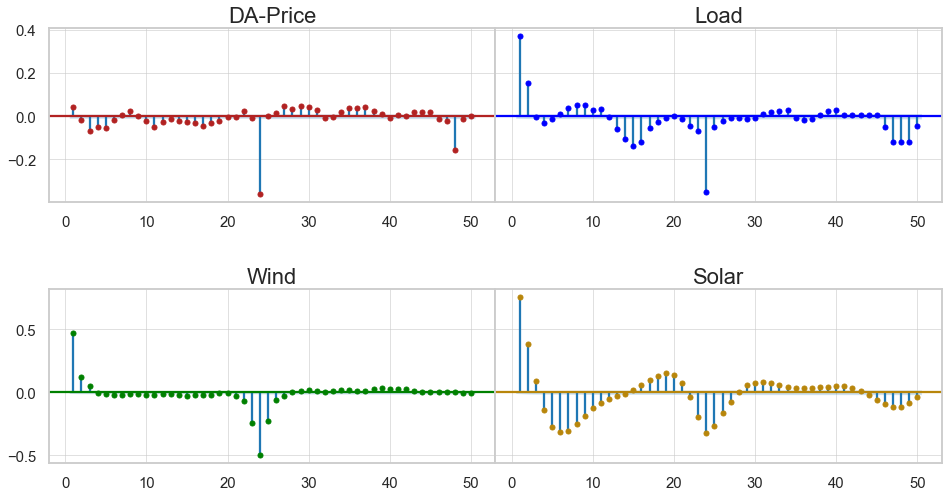

In [32]:
# TEST: Autocorrelation Diff lag(1) +  Diff lag(24)
g = train[data_columns].diff(1).dropna()
g = g.diff(24).dropna()
auto_correlation_plot_2(g)

### TEST NOT WORKING: Auto-order select with IC 

In [ ]:
# for enum, column in enumerate(data_columns):    
resDiff = sm.tsa.arma_order_select_ic(train["Load"], max_ar=2, max_ma=2, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

### RUN 01

In [8]:
arima = sm.tsa.statespace.SARIMAX(
    train["Load"],
#     freq='',
    enforce_stationarity=False, 
    enforce_invertibility=False,
    order=(1,1,0), seasonal_order=(7,1,7,7),
).fit()
arima.summary()

C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-f17ddda19ed4>", line 6, in <module>
    order=(1,1,0), seasonal_order=(7,1,7,7),
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 659, in fit
    skip_hessian=True, **kwargs)
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\base\model.py", line 526, in fit
    full_output=full_output)
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\base\optimizer.py", line 218, in _fit
    hess=hessian)
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\statsmodels\base\optimizer.py", line 440, in _fit_lbfgs
    **extra_kwargs)
  File "C:\Users\WGO\Miniconda3\envs\ecast\lib\site-packages\scipy\optimize\lbfgsb.py", line 198, in fmin_l_bfgs_b
    **opts)
  File

TypeError: object of type 'NoneType' has no len()

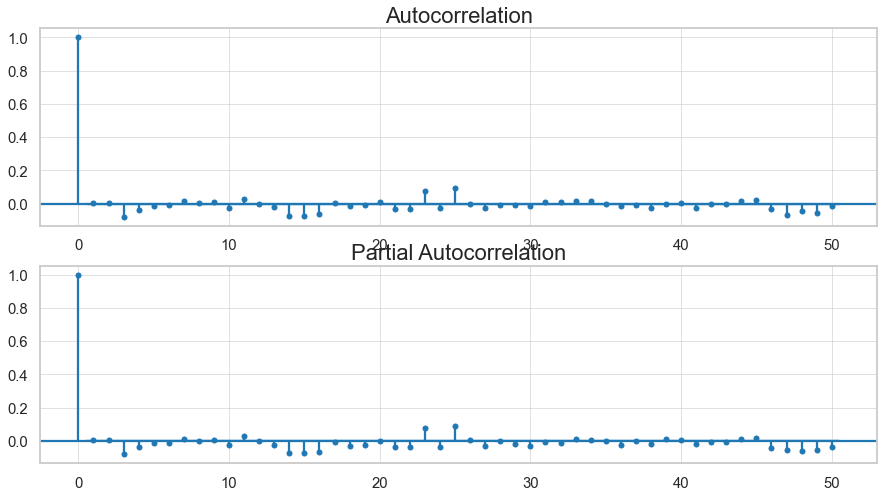

In [70]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

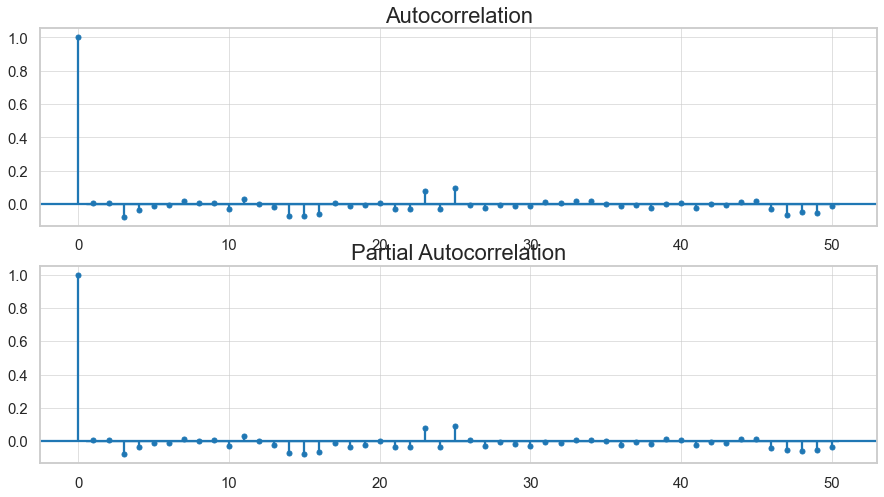

In [54]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

ARIMA model MSE:2759879.5117946034


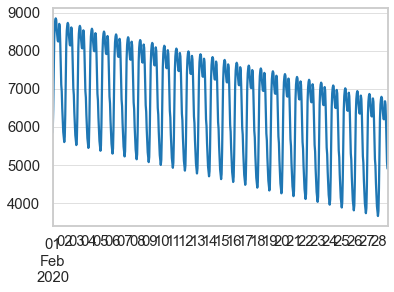

In [71]:
from sklearn.metrics import mean_squared_error
prediction = arima.predict(train_end,test_end)[1:]
prediction.plot()
print('ARIMA model MSE:{}'.format(mean_squared_error(test["Load"],prediction)))

In [15]:
round(prediction,2)

NameError: name 'prediction' is not defined

In [44]:
t.index[-1]
t

DA-Price   Wind  Solar   Load
2015-01-02 02:00:00      0.18  -31.0    0.0 -223.0
2015-01-02 03:00:00      0.03   53.0    0.0    3.0
2015-01-02 04:00:00     -3.07   68.0    0.0   78.0
2015-01-02 05:00:00      3.60   31.0    0.0  183.0
2015-01-02 06:00:00     -0.50   13.0    0.0  266.0
...                       ...    ...    ...    ...
2020-01-31 19:00:00    -12.15  102.0    0.0  129.0
2020-01-31 20:00:00     -2.62  333.0    0.0   23.0
2020-01-31 21:00:00     -0.27 -254.0    0.0 -106.0
2020-01-31 22:00:00      5.74 -503.0    0.0  -37.0
2020-01-31 23:00:00      3.15 -511.0    0.0  -42.0

[44542 rows x 4 columns]

In [37]:
results_df = pd.concat(
    [result.seasonal, result.trend, result.resid, result.observed],
    axis=1)
results_df.columns = ['Seasonal', 'Trend', 'Residuals', 'Aggregated']


2015-01-31    1.13
2015-02-28    1.14
2015-03-31    1.06
2015-04-30    0.94
2015-05-31    0.91
              ... 
2020-04-30    0.94
2020-05-31    0.91
2020-06-30    0.92
2020-07-31    0.92
2020-08-31    0.90
Freq: M, Name: Seasonal, Length: 68, dtype: float64

In [41]:
b = s.resample("H").mean().ffill()
b

2015-01-31 00:00:00    1.13
2015-01-31 01:00:00    1.13
2015-01-31 02:00:00    1.13
2015-01-31 03:00:00    1.13
2015-01-31 04:00:00    1.13
                       ... 
2020-08-30 20:00:00    0.92
2020-08-30 21:00:00    0.92
2020-08-30 22:00:00    0.92
2020-08-30 23:00:00    0.92
2020-08-31 00:00:00    0.90
Freq: H, Name: Seasonal, Length: 48937, dtype: float64

In [40]:
cleaned = t.values / b.values

ValueError: operands could not be broadcast together with shapes (44542,4) (2040,) 

In [31]:
h

2015-01-31 00:00:00  2015-02-01 00:00:00  \
2015-01-02 02:00:00                  NaN                  NaN   
2015-01-02 03:00:00                  NaN                  NaN   
2015-01-02 04:00:00                  NaN                  NaN   
2015-01-02 05:00:00                  NaN                  NaN   
2015-01-02 06:00:00                  NaN                  NaN   
...                                  ...                  ...   
2020-01-31 19:00:00                  NaN                  NaN   
2020-01-31 20:00:00                  NaN                  NaN   
2020-01-31 21:00:00                  NaN                  NaN   
2020-01-31 22:00:00                  NaN                  NaN   
2020-01-31 23:00:00                  NaN                  NaN   

                     2015-02-02 00:00:00  2015-02-03 00:00:00  \
2015-01-02 02:00:00                  NaN                  NaN   
2015-01-02 03:00:00                  NaN                  NaN   
2015-01-02 04:00:00                  NaN                  NaN   
2015-01-02 05:00:00                  NaN                  NaN   
2015-01-02 06:00:00                  NaN                  NaN   
...                                  ...                  ...   
2020-01-31 19:00:00                  NaN                  NaN   
2020-01-31 20:00:00                  NaN                  NaN   
2020-01-31 21:00:00                  NaN                  NaN   
2020-01-31 22:00:00                  NaN                  NaN   
2020-01-31 23:00:00                  NaN                  NaN   

                     2015-02-04 00:00:00  2015-02-05 00:00:00  \
2015-01-02 02:00:00                  NaN                  NaN   
2015-01-02 03:00:00                  NaN                  NaN   
2015-01-02 04:00:00                  NaN                  NaN   
2015-01-02 05:00:00                  NaN                  NaN   
2015-01-02 06:00:00                  NaN                  NaN   
...                                  ...                  ...   
2020-01-31 19:00:00                  NaN                  NaN   
2020-01-31 20:00:00                  NaN                  NaN   
2020-01-31 21:00:00                  NaN                  NaN   
2020-01-31 22:00:00                  NaN                  NaN   
2020-01-31 23:00:00                  NaN                  NaN   

                     2015-02-06 00:00:00  2015-02-07 00:00:00  \
2015-01-02 02:00:00                  NaN                  NaN   
2015-01-02 03:00:00                  NaN                  NaN   
2015-01-02 04:00:00                  NaN                  NaN   
2015-01-02 05:00:00                  NaN                  NaN   
2015-01-02 06:00:00                  NaN                  NaN   
...                                  ...                  ...   
2020-01-31 19:00:00                  NaN                  NaN   
2020-01-31 20:00:00                  NaN                  NaN   
2020-01-31 21:00:00                  NaN                  NaN   
2020-01-31 22:00:00                  NaN                  NaN   
2020-01-31 23:00:00                  NaN                  NaN   

                     2015-02-08 00:00:00  2015-02-09 00:00:00  ...  \
2015-01-02 02:00:00                  NaN                  NaN  ...   
2015-01-02 03:00:00                  NaN                  NaN  ...   
2015-01-02 04:00:00                  NaN                  NaN  ...   
2015-01-02 05:00:00                  NaN                  NaN  ...   
2015-01-02 06:00:00                  NaN                  NaN  ...   
...                                  ...                  ...  ...   
2020-01-31 19:00:00                  NaN                  NaN  ...   
2020-01-31 20:00:00                  NaN                  NaN  ...   
2020-01-31 21:00:00                  NaN                  NaN  ...   
2020-01-31 22:00:00                  NaN                  NaN  ...   
2020-01-31 23:00:00                  NaN                  NaN  ...   

                     2020-08-26 00:00:00  2020-08-27 00:

<AxesSubplot:>

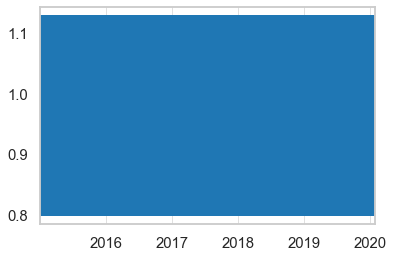

In [29]:
result.seasonal.plot()